In [1]:
import torch
import warnings
warnings.filterwarnings('ignore')
torch.set_default_tensor_type(torch.DoubleTensor)
import random
import math
import torch.nn as nn
from torch.nn import functional as F
from collections import defaultdict
import torch
from mingpt.utils import CfgNode as CN
from tqdm.auto import tqdm
torch.set_default_tensor_type(torch.DoubleTensor)
import scanpy as sc
from torch.utils.data import (DataLoader, Dataset)
import numpy as np
import os
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# 定义一些分类模型
models = {
    'Logistic Regression': LogisticRegression(random_state=2024),
    'Decision Tree': DecisionTreeClassifier(random_state=2024),
    'Random Forest': RandomForestClassifier(random_state=2024),
    'SVM_linear': SVC(decision_function_shape="ovr", kernel="linear", random_state=2024),
    'SVM_rbf': SVC(decision_function_shape="ovr", kernel="rbf", random_state=2024),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB()
}


def same_seeds(seed):
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Torch
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True


same_seeds(2024)

class CausalSelfAttention(nn.Module):

    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        # key, query, value projections for all heads, but in a batch
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd)
        # output projection
        self.c_proj = nn.Linear(config.n_embd, config.n_embd)
        # regularization
        self.attn_dropout = nn.Dropout(config.attn_pdrop)
        self.resid_dropout = nn.Dropout(config.resid_pdrop)
        # causal mask to ensure that attention is only applied to the left in the input sequence
        self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size))
                             .view(1, 1, config.block_size, config.block_size))
        self.n_head = config.n_head
        self.n_embd = config.n_embd

    def forward(self, x):
        B, T, C = x.size()  # batch size, sequence length, embedding dimensionality (n_embd)
        # print("B, T, C",B, T, C)
        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        q, k, v = self.c_attn(x).split(self.n_embd, dim=2)
        # print("q, k, v",q, k, v)
        q = F.relu(q)
        k = F.relu(k)
        v = F.relu(v)

        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)  # (B, nh, T, hs)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)  # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)  # (B, nh, T, hs)

        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        att = att.masked_fill(self.bias[:, :, :T, :T] == 0, float('-inf'))
        # att = F.softmax(att, dim=-1)
        att = F.relu(att)
        att = self.attn_dropout(att)
        y = att @ v  # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)
        y = y.transpose(1, 2).contiguous().view(B, T, C)  # re-assemble all head outputs side by side

        y = self.resid_dropout(self.c_proj(y))
        return y

class Block(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.ln_1 = nn.LayerNorm(config.n_embd)
        self.attn = CausalSelfAttention(config)
        self.ln_2 = nn.LayerNorm(config.n_embd)
        self.mlp = nn.ModuleDict(dict(
            c_fc=nn.Linear(config.n_embd, 2 * config.n_embd),
            c_proj=nn.Linear(2 * config.n_embd, config.n_embd),
            act=nn.ReLU(),
            dropout=nn.Dropout(config.resid_pdrop),
        ))
        m = self.mlp
        self.mlpf = lambda x: m.dropout(m.c_proj(m.act(m.c_fc(x))))  # MLP forward

    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlpf(self.ln_2(x))
        return x

class scDataSet(Dataset):
    def __init__(self, data, label):
        self.data = data
        self.label = label
        self.length = len(data)

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        data = torch.from_numpy(self.data)
        label = torch.from_numpy(self.label)

        x = torch.tensor(data[idx])
        y = torch.tensor(label[idx])
        return x, y

class GPT(nn.Module):

    @staticmethod
    def get_default_config():
        C = CN()
        # either model_type or (n_layer, n_head, n_embd) must be given in the config
        C.model_type = 'gpt'
        C.n_layer = None
        C.n_head = None
        C.n_embd = None
        # these options must be filled in externally
        C.vocab_size = None
        C.block_size = None
        # dropout hyperparameters
        C.embd_pdrop = 0.1
        C.resid_pdrop = 0.1
        C.attn_pdrop = 0.1
        C.entreg = .1
        C.p = 2
        C.h = 2
        C.loss1 = 50
        C.mod2_dim = 134
        return C

    def __init__(self, config):
        super().__init__()
        assert config.vocab_size is not None
        assert config.block_size is not None
        self.block_size = config.block_size
        self.conf = config
        type_given = config.model_type is not None
        params_given = all([config.n_layer is not None, config.n_head is not None, config.n_embd is not None])
        assert type_given ^ params_given  # exactly one of these (XOR)
        if type_given:
            # translate from model_type to detailed configuration
            config.merge_from_dict({
                                       # names follow the huggingface naming conventions
                                       # GPT-1
                                       'openai-gpt': dict(n_layer=12, n_head=12, n_embd=768),  # 117M params
                                       # GPT-2 configs
                                       'gpt2': dict(n_layer=12, n_head=12, n_embd=768),  # 124M params
                                       'gpt2-medium': dict(n_layer=24, n_head=16, n_embd=1024),  # 350M params
                                       'gpt2-large': dict(n_layer=36, n_head=20, n_embd=1280),  # 774M params
                                       'gpt2-xl': dict(n_layer=48, n_head=25, n_embd=1600),  # 1558M params
                                       # Gophers
                                       'gopher-44m': dict(n_layer=8, n_head=16, n_embd=512),
                                       # (there are a number more...)
                                       # I made these tiny models up
                                       'gpt-mini': dict(n_layer=6, n_head=6, n_embd=192),
                                       'gpt-micro': dict(n_layer=4, n_head=4, n_embd=128),
                                       'gpt-nano': dict(n_layer=1, n_head=config.h, n_embd=config.n_embd),
                                   }[config.model_type])
        print("config.vocab_size, config.n_embd", config.vocab_size, config.n_embd)
        self.pro = nn.Linear(config.vocab_size, config.n_embd)
        self.transformer = nn.ModuleDict(dict(
            wpe=nn.Embedding(config.block_size, config.n_embd),
            drop=nn.Dropout(config.embd_pdrop),
            h=nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            ln_f=nn.LayerNorm(config.n_embd),
        ))  # config.n_embd*config.block_size
        # self.lm_head = nn.Linear(config.n_embd, config.mod2_dim, bias=False)
        self.lm_head = nn.Linear(config.n_embd, config.mod2_dim)  # , bias=False
        # init all weights, and apply a special scaled init to the residual projections, per GPT-2 paper
        self.apply(self._init_weights)
        for pn, p in self.named_parameters():
            if pn.endswith('c_proj.weight'):
                torch.nn.init.normal_(p, mean=0.0, std=0.02 / math.sqrt(2 * config.n_layer))

        # # report number of parameters (note we don't count the decoder parameters in lm_head)
        # n_params = sum(p.numel() for p in self.transformer.parameters())
        # print("number of parameters: %.2fM" % (n_params / 1e6,))

    def cross_mod(self, mod1, mod2=None):
        idx = torch.tensor(mod1, dtype=torch.double)
        device = idx.device
        b, t, v = idx.size()
        num_cls = int(self.conf.block_size/2)
        cls1 = torch.zeros(num_cls).long().to(device)
        cls2 = torch.ones(num_cls).long().to(device)
        cls = torch.cat((cls1, cls2), dim=0).to(device)
        pos = torch.arange(0, t, dtype=torch.long, device=device).unsqueeze(0)

        pos_emb = self.transformer.wpe(pos)  # position embeddings of shape (1, t, n_embd)
        cls_emb = self.transformer.wpe(cls) # + cls_emb

        x = self.transformer.drop(idx + pos_emb) # + cls_emb
        for block in self.transformer.h:
            x = F.relu(x)
            x = block(x)
        x = F.relu(x)
        x = self.transformer.ln_f(x)
        x = F.relu(x)
        x = torch.mean(x, dim=1)
        emb = x
        logits = self.lm_head(x)
        mod_logits = F.relu(logits)

        # if we are given some desired targets also calculate the loss
        loss = None
        # criterion = nn.CrossEntropyLoss()

        if mod2 is not None:
            targets = torch.tensor(mod2, dtype=torch.double)
            loss1 = F.mse_loss(mod_logits, targets) ** 0.5
            loss = loss1  # loss1 #+ loss2
        return loss, emb,mod_logits

    def forward(self, X, Y):

        loss1, emb_mod,mod1_logits2 = self.cross_mod(X, Y)

        loss = self.conf.loss1*loss1
        return emb_mod, loss,mod1_logits2

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
        elif isinstance(module, nn.LayerNorm):
            torch.nn.init.zeros_(module.bias)
            torch.nn.init.ones_(module.weight)

    def configure_optimizers(self, train_config):
        """
        This long function is unfortunately doing something very simple and is being very defensive:
        We are separating out all parameters of the model into two buckets: those that will experience
        weight decay for regularization and those that won't (biases, and layernorm/embedding weights).
        We are then returning the PyTorch optimizer object.
        """

        # separate out all parameters to those that will and won't experience regularizing weight decay
        decay = set()
        no_decay = set()
        whitelist_weight_modules = (torch.nn.Linear,)
        blacklist_weight_modules = (torch.nn.LayerNorm, torch.nn.Embedding)
        for mn, m in self.named_modules():
            for pn, p in m.named_parameters():
                fpn = '%s.%s' % (mn, pn) if mn else pn  # full param name
                # random note: because named_modules and named_parameters are recursive
                # we will see the same tensors p many many times. but doing it this way
                # allows us to know which parent module any tensor p belongs to...
                if pn.endswith('bias'):
                    # all biases will not be decayed
                    no_decay.add(fpn)
                elif pn.endswith('weight') and isinstance(m, whitelist_weight_modules):
                    # weights of whitelist modules will be weight decayed
                    decay.add(fpn)
                elif pn.endswith('weight') and isinstance(m, blacklist_weight_modules):
                    # weights of blacklist modules will NOT be weight decayed
                    no_decay.add(fpn)

        # validate that we considered every parameter
        param_dict = {pn: p for pn, p in self.named_parameters()}
        inter_params = decay & no_decay
        union_params = decay | no_decay
        assert len(inter_params) == 0, "parameters %s made it into both decay/no_decay sets!" % (str(inter_params),)
        assert len(
            param_dict.keys() - union_params) == 0, "parameters %s were not separated into either decay/no_decay set!" \
                                                    % (str(param_dict.keys() - union_params),)

        # create the pytorch optimizer object
        optim_groups = [
            {"params": [param_dict[pn] for pn in sorted(list(decay))], "weight_decay": train_config.weight_decay},
            {"params": [param_dict[pn] for pn in sorted(list(no_decay))], "weight_decay": 0.0},
        ]
        optimizer = torch.optim.AdamW(optim_groups, lr=train_config.learning_rate, betas=train_config.betas) #,weight_decay=train_config.weight_decay
        return optimizer


from typing import Tuple
import scipy


def foscttm(
        x: np.ndarray, y: np.ndarray, **kwargs
) -> Tuple[np.ndarray, np.ndarray]:
    if x.shape != y.shape:
        raise ValueError("Shapes do not match!")
    d = scipy.spatial.distance_matrix(x, y, **kwargs)
    foscttm_x = (d < np.expand_dims(np.diag(d), axis=1)).mean(axis=1)
    foscttm_y = (d < np.expand_dims(np.diag(d), axis=0)).mean(axis=0)
    return foscttm_x, foscttm_y

class Trainer:

    @staticmethod
    def get_default_config():
        C = CN()
        # device to train on
        C.device = 'auto'
        # dataloder parameters
        C.num_workers = 1
        # optimizer parameters
        C.epoch = 100
        C.batch_size = 64
        C.learning_rate = 3e-4
        C.betas = (0.95, 0.99)
        C.weight_decay = 0.1  # only applied on matmul weights
        C.grad_norm_clip = 1.0
        return C

    def __init__(self, config, model, train_dataset):
        self.config = config
        self.model = model
        self.optimizer = None
        self.train_dataset = train_dataset
        self.callbacks = defaultdict(list)
        # determine the device we'll train on
        if config.device == 'auto':
            self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        else:
            self.device = config.device
        self.model = self.model.to(self.device)
        print("running on device", self.device)

        # variables that will be assigned to trainer class later for logging and etc
        self.iter_num = 0
        self.iter_time = 0.0
        self.iter_dt = 0.0

    def run(self):
        model, config = self.model, self.config
        model = model.to(self.device)
        # setup the optimizer
        self.optimizer = model.configure_optimizers(config)#.to(self.device)

        train_loader = DataLoader(self.train_dataset, batch_size=config.batch_size, shuffle=False,
                                  pin_memory=True)

        model.train()
        n_epochs = config.epoch
        for epoch in range(n_epochs):

            train_loss = []
            train_loss1 = []
            train_loss3 = []
            emb_mods = []
            emb_mod2s = []
            mod1_logits2s = []
            mod2_logits1s = []
            for batch in tqdm(train_loader):
                X, Y, = batch
                X = X.to(self.device)
                Y = Y.to(self.device)
                emb_mod,self.loss,mod1_logits2 = model(X, Y)
                model.zero_grad(set_to_none=True)
                self.loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), config.grad_norm_clip)
                self.optimizer.step()
                train_loss.append(self.loss.item())


                if(self.device == 'cuda'):
                    emb_mods.extend(emb_mod.cpu().detach().numpy()) #.numpy()
                else:
                    emb_mods.extend(emb_mod.detach().numpy()) #.numpy()

            train_loss = sum(train_loss) / len(train_loss)


            print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss:.5f},")

        emb_mods = np.asarray(emb_mods)


        return emb_mods#, mod2_logits1s


def GeneEmbeding(X, gap):
    num_cells = len(X)
    num_features = (len(X[0]) + gap - 1) // gap
    shape = (num_cells, num_features, gap)

    # 使用内存映射文件来存储大数组
    mmap = np.memmap('gene_embedding2.dat', dtype='float32', mode='w+', shape=shape)

    for cell_index, single_cell in enumerate(X):
        # 对于每个single_cell，我们已经知道特征的数量
        for feature_index in range(0, len(single_cell), gap):
            end_index = feature_index + gap
            # 处理边界情况
            if end_index > len(single_cell):
                feature = single_cell[-gap:]
            else:
                feature = single_cell[feature_index:end_index]

            # 将特征放入内存映射文件中相应的位置
            mmap[cell_index, feature_index // gap, :] = feature

    # 刷新内存映射文件以确保所有数据都写入磁盘
    mmap.flush()

    print("gene_embedding.dat mmap.shape", mmap.shape)
    return mmap

def getXY2(mod_paths, mod_names, gap):
    path = "../../../Datasets/Arabidopsis thaliana/All/" +"/"
    adata_mod = sc.read_h5ad(path + "Arabidopsis_all_8000_BatchExper.h5ad")

    # step1: 获得两种模态数据并且进行预处理
    adata_mod1 = sc.read_h5ad(mod_paths[0] + mod_names[0])
    adata_mod1.var_names_make_unique()
    adata_mod1.obs['domain_id'] = "0"

    print("adata_mod1",adata_mod1)
    sc.pp.filter_genes(adata_mod1,min_counts=1)
    print("adata_mod1",adata_mod1)

#     for n_top in range(2000,adata_mod1.shape[1],500):
#         sc.pp.highly_variable_genes(adata_mod1, n_top_genes=n_top)
#         adata_mod_temp = adata_mod1[:, adata_mod1.var.highly_variable]
#         adata_mod1_con = adata_mod.concatenate(adata_mod_temp)
#         n_top_con = adata_mod1_con.shape[1]
#         if(n_top_con > 2500):
#             break

            
#     print("adata_mod1_con",adata_mod1_con)   
#     print("adata_mod_temp",adata_mod_temp)   
    
    adata_mod1_all = adata_mod.concatenate(adata_mod1, join="outer")
    adata_mod1 = adata_mod1_all[len(adata_mod):]
    adata_mod1 = adata_mod1[:, adata_mod.var_names.values]  
#     adata_mod1 = adata_mod1[:, adata_mod.var['features'].values]

    X1 = adata_mod1.X#obsm['X_pca']#.todense()
    if not isinstance(X1, np.ndarray):
        X1 = X1.todense()


    X1 = np.asarray(X1)

    Y1 = X1
    X1 = GeneEmbeding(X1, gap)

    batch_list = adata_mod1.obs["Dataset"].values

    return X1,Y1,adata_mod1,batch_list # single_cell_list, labelss, cell_types
import time
gap = 128
# np.unique(data1.obs["Celltype"],)

# experiments2 = ['07SRP169576_norm',"06SRP166333_norm",]
path = "../../../Datasets/Arabidopsis thaliana/Root//" +"/"
test_paths = [path]
test_names = ["05SRP171040_new_rice_SRP309176_filter.h5ad",]

X1,Y1,adata_mod1,batch_list = getXY2(test_paths, test_names, gap)
adata_mod1_raw = adata_mod1
print("train_mod1.shape", X1.shape)
print("train_mod2.shape", Y1.shape)

from collections import Counter
# 计算每个元素的个数
counts = Counter(batch_list)
# 根据batch_list中的顺序获取计数
unique_indices = list(counts.keys())
counts_in_order = list(counts.values())
print(unique_indices)

index_max = np.argmax(counts_in_order)

start = time.time()

a, b, c = X1.shape
print("a,b,c,", a, b, c)
train_dataset = scDataSet(data = X1, label = Y1)

model_name = "integration_end_v6"
model_config = GPT.get_default_config()
model_config.model_type = 'gpt-nano'
model_config.vocab_size = gap
model_config.block_size = b
model_config.n_embd = gap
model_config.embd_pdrop = 0.0
model_config.resid_pdrop = 0.0
model_config.attn_pdrop = 0.0
model_config.loss1 = 1
model_config.h = 32
model_config.mod2_dim = Y1.shape[1]
print("model_config.mod2_dim ", model_config.mod2_dim)
print("model_config.vocab_size", model_config.vocab_size)
premodel2 = GPT(model_config)
# 加载保存的模型状态字典
pre_train_model_name = "Arabidopsis_all_8000_BatchExper"

pre_epoch = 100
log_dir = "../../log/" + str(model_name) + "/"+ str(pre_epoch) + "/" + str("0.75") + "/" + pre_train_model_name + "/" #
premodel2.load_state_dict(torch.load(log_dir + 'scPlantGPT.pth'))
model_name = "integarte_v1/" + pre_train_model_name + "/"+"/0.75/"

train_config = Trainer.get_default_config()
train_config.epoch = 10
train_config.learning_rate = 1e-4
train_config.batch_size = 256  # 10240
trainer2 = Trainer(train_config, premodel2, train_dataset)

log_dir = "log/" + str(model_name) + "/pre_epoch="+ str(pre_epoch) + "/lr=" + str(model_config.attn_pdrop) +"/epoch=" + str(train_config.epoch) +"//"+ test_names[0] +"//"
if (not os.path.isdir(log_dir)):
    os.makedirs(log_dir)

emb_mod1s = trainer2.run() #mod2_logits1s



adata_mod1 AnnData object with n_obs × n_vars = 71222 × 53678
    obs: 'Orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Percent.mt', 'Seurat_clusters', 'Celltype', 'Dataset', 'Tissue', 'Organ', 'Condition', 'Genotype', 'Libraries', 'ACE', 'experiments', 'batch', 'domain_id'
    var: 'features-0', 'features-1', 'rice gene-1', 'arabidopsis gene-1'
    obsm: 'X_umap'
adata_mod1 AnnData object with n_obs × n_vars = 71222 × 32735
    obs: 'Orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Percent.mt', 'Seurat_clusters', 'Celltype', 'Dataset', 'Tissue', 'Organ', 'Condition', 'Genotype', 'Libraries', 'ACE', 'experiments', 'batch', 'domain_id'
    var: 'features-0', 'features-1', 'rice gene-1', 'arabidopsis gene-1', 'n_counts'
    obsm: 'X_umap'
gene_embedding.dat mmap.shape (71222, 63, 128)
train_mod1.shape (71222, 63, 128)
train_mod2.shape (71222, 8000)
['SRP171040', 'SRP309176']
a,b,c, 71222 63 128
model_config.mod2_dim  8000
model_config.vocab_size 128
config.vocab_size, config.n_embd 128 128
runnin

  0%|          | 0/279 [00:00<?, ?it/s]

[ Train | 001/010 ] loss = 0.28529,


  0%|          | 0/279 [00:00<?, ?it/s]

[ Train | 002/010 ] loss = 0.25838,


  0%|          | 0/279 [00:00<?, ?it/s]

[ Train | 003/010 ] loss = 0.24871,


  0%|          | 0/279 [00:00<?, ?it/s]

[ Train | 004/010 ] loss = 0.24411,


  0%|          | 0/279 [00:00<?, ?it/s]

[ Train | 005/010 ] loss = 0.24151,


  0%|          | 0/279 [00:00<?, ?it/s]

[ Train | 006/010 ] loss = 0.23982,


  0%|          | 0/279 [00:00<?, ?it/s]

[ Train | 007/010 ] loss = 0.23866,


  0%|          | 0/279 [00:00<?, ?it/s]

[ Train | 008/010 ] loss = 0.23774,


  0%|          | 0/279 [00:00<?, ?it/s]

[ Train | 009/010 ] loss = 0.23696,


  0%|          | 0/279 [00:00<?, ?it/s]

[ Train | 010/010 ] loss = 0.23626,


In [2]:
adata_mod1.obsm["emb_mod1s"] = emb_mod1s
raw_embed = emb_mod1s

In [3]:
import ot
def fit_transform_sinkhorn(Xs, Xt, reg=0.3):
    """Fit and transform using Sinkhorn algorithm."""
    ot_sinkhorn = ot.da.LinearTransport(reg=reg)
    ot_sinkhorn.fit(Xs=Xs, Xt=Xt)
    return ot_sinkhorn.transform(Xs=Xs)

In [4]:
adata_mod1.obs["Dataset"] = adata_mod1.obs["Dataset"].astype('category')
adata_mod1.obs["Celltype"] = adata_mod1.obs["Celltype"].astype('category')

In [5]:
import pandas as pd
adata_mod1.var = pd.DataFrame(index=adata_mod1.var_names)

In [6]:
import scanpy as sc
import scib
import scanpy as sc
import numpy as np
import scib

In [7]:
reg_ = 0
emb_mod1s = raw_embed
groups = {}
# 遍历所有的索引和特征
for i, idx in enumerate(batch_list):
    if idx not in groups:
        groups[idx] = []
    groups[idx].append(emb_mod1s[i])
# 将分组列表转换为NumPy数组
for k in groups:
    groups[k] = np.array(groups[k])


emb_mod1s_max = groups[unique_indices[index_max]]
for i in unique_indices:
    if(i != index_max):
        groups[i] = fit_transform_sinkhorn(groups[i], emb_mod1s_max, reg=reg_)


emb_mod1s_ = groups[unique_indices[0]]
for i in unique_indices[1:]:
    emb_mod1s_ = np.concatenate((emb_mod1s_, groups[i]), axis=0)
    
adata_mod1.obsm["X_scmGPT_" + str(reg_)] = emb_mod1s_
sc.pp.neighbors(adata_mod1, use_rep="X_scmGPT_" + str(reg_),) # metric="cosine"
X_scmGPT_metrics_combined = scib.metrics.metrics_fast(adata_mod1, adata_mod1, "Dataset", "Celltype", embed="X_scmGPT_" + str(reg_))
print("X_scmGPT_metrics_combined",X_scmGPT_metrics_combined)

C:\D\software\conda3\lib\site-packages\numba\np\ufunc\parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


Silhouette score...


C:\D\software\conda3\lib\site-packages\anndata\_core\anndata.py:1118: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
C:\D\software\conda3\lib\site-packages\anndata\_core\anndata.py:1118: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
C:\D\software\conda3\lib\site-packages\anndata\_core\anndata.py:1118: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
C:\D\software\conda3\lib\site-packages\anndata\_core\anndata.py:1118: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  i

PC regression...


C:\D\software\conda3\lib\site-packages\scanpy\preprocessing\_pca.py:185: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = AnnData(data)
C:\D\software\conda3\lib\site-packages\scanpy\preprocessing\_pca.py:385: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)


Isolated labels ASW...


C:\D\software\conda3\lib\site-packages\scib\metrics\isolated_labels.py:272: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  batch_per_lab = tmp.groupby(label_key).agg({batch_key: "count"})


Graph connectivity...


C:\D\software\conda3\lib\site-packages\anndata\_core\anndata.py:1118: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
C:\D\software\conda3\lib\site-packages\scib\metrics\graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
C:\D\software\conda3\lib\site-packages\anndata\_core\anndata.py:1118: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
C:\D\software\conda3\lib\site-packages\scib\metrics\graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(la

C:\D\software\conda3\lib\site-packages\scib\metrics\highly_variable_genes.py:35: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hvg_dir[i.obs[batch][0]] = i.var.index[hvg["highly_variable"]]
C:\D\software\conda3\lib\site-packages\anndata\_core\anndata.py:1118: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
C:\D\software\conda3\lib\site-packages\scib\metrics\highly_variable_genes.py:35: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hvg_dir[i.obs[batch][0]] = i.var.index[hvg["hig

X_scmGPT_metrics_combined                                   0
NMI_cluster/label               NaN
ARI_cluster/label               NaN
ASW_label                  0.494917
ASW_label/batch            0.867993
PCR_batch                  1.000000
cell_cycle_conservation         NaN
isolated_label_F1               NaN
isolated_label_silhouette  0.524421
graph_conn                 0.950614
kBET                            NaN
iLISI                           NaN
cLISI                           NaN
hvg_overlap                1.000000
trajectory                      NaN


C:\D\software\conda3\lib\site-packages\anndata\_core\anndata.py:1118: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
C:\D\software\conda3\lib\site-packages\scib\metrics\highly_variable_genes.py:76: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  batch_var = ad_post.obs[batch_key][0]


In [8]:
data_name = "SRP332285_new_rice_SRP309176_filter_all"

C:\D\software\conda3\lib\site-packages\fontTools\misc\py23.py:11: DeprecationWarning: The py23 module has been deprecated and will be removed in a future release. Please update your code.
  warnings.warn(


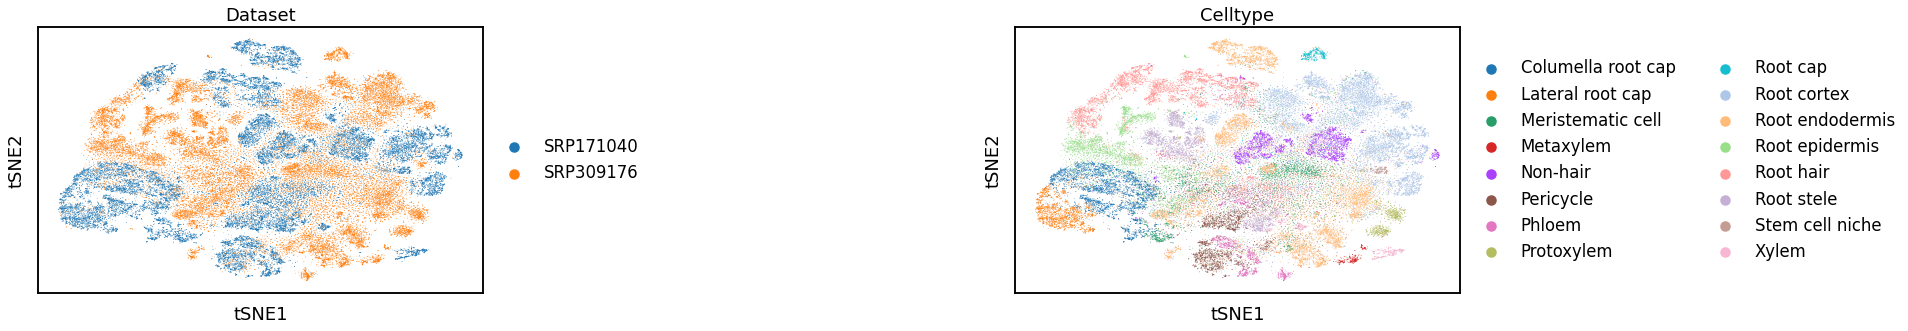

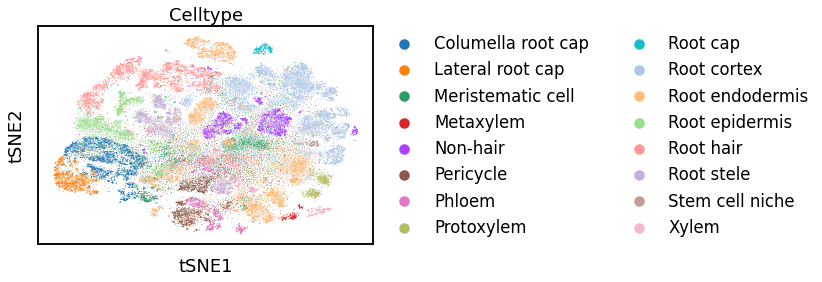

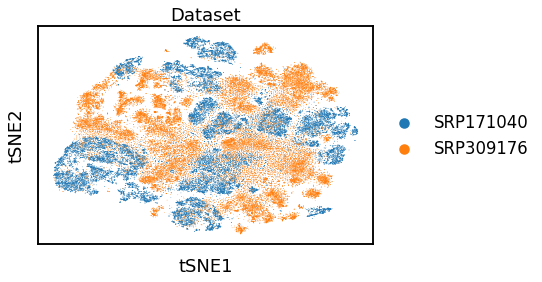

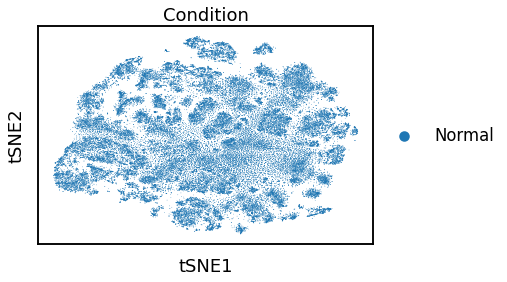

In [9]:
use_rep_name = "X_scmGPT_0"
sc.tl.tsne(adata_mod1, use_rep=use_rep_name)
sc.pl.tsne(adata_mod1, color=["Dataset", "Celltype"], wspace=1,save= data_name + use_rep_name + '_tsne_plot.pdf')
sc.pl.tsne(adata_mod1, color=["Celltype"], wspace=1,save= data_name + use_rep_name + 'Celltype_tsne_plot.pdf')
sc.pl.tsne(adata_mod1, color=["Dataset"], wspace=1,save= data_name + use_rep_name + 'experiments_tsne_plot.pdf')
sc.pl.tsne(adata_mod1, color=["Condition"], wspace=1,save= data_name + use_rep_name + 'Condition_tsne_plot.pdf')

In [10]:
adata_mod1.obs["Celltype"].value_counts()

Celltype
Root cortex           13400
Root endodermis       12973
Root hair              7884
Columella root cap     5640
Root epidermis         5287
Non-hair               4242
Root stele             4230
Meristematic cell      4116
Pericycle              4005
Phloem                 2596
Lateral root cap       2537
Protoxylem             1526
Xylem                  1030
Root cap                808
Metaxylem               521
Stem cell niche         427
Name: count, dtype: int64

In [11]:
adata_mod1_new = adata_mod1

In [12]:
# adata_mod1_new = adata_mod1[adata_mod1.obs["Celltype"].isin(["Root cortex","Root endodermis","Root hair",
#                                                             "Columella root cap","Root epidermis","Non-hair",
#                                                             "Root stele","Meristematic cell","Pericycle",
#                                                             "Phloem","Lateral root cap","Protoxylem",
#                                                             "Xylem","Root cap","Metaxylem","Stem cell niche",]) ]

In [13]:
adata_mod1_new.obs["newCelltype"] = adata_mod1_new.obs["Celltype"]
adata_mod1_new.obs["newCelltype"].replace(to_replace='Root hair', value='Root epidermis', inplace=True)
adata_mod1_new.obs["newCelltype"].replace(to_replace='Non-hair', value='Root epidermis', inplace=True)
adata_mod1_new.obs["newCelltype"].replace(to_replace='Stem cell niche', value='Meristematic cell', inplace=True)
adata_mod1_new.obs["newCelltype"].replace(to_replace='Protoxylem', value='Xylem', inplace=True)
adata_mod1_new.obs["newCelltype"].replace(to_replace='Metaxylem', value='Xylem', inplace=True)
adata_mod1_new.obs["newCelltype"].value_counts()

C:\Users\xumuzhi\AppData\Local\Temp\ipykernel_44476\3349725268.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  adata_mod1_new.obs["newCelltype"].replace(to_replace='Root hair', value='Root epidermis', inplace=True)
C:\Users\xumuzhi\AppData\Local\Temp\ipykernel_44476\3349725268.py:2: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categ

newCelltype
Root epidermis        17413
Root cortex           13400
Root endodermis       12973
Columella root cap     5640
Meristematic cell      4543
Root stele             4230
Pericycle              4005
Xylem                  3077
Phloem                 2596
Lateral root cap       2537
Root cap                808
Name: count, dtype: int64

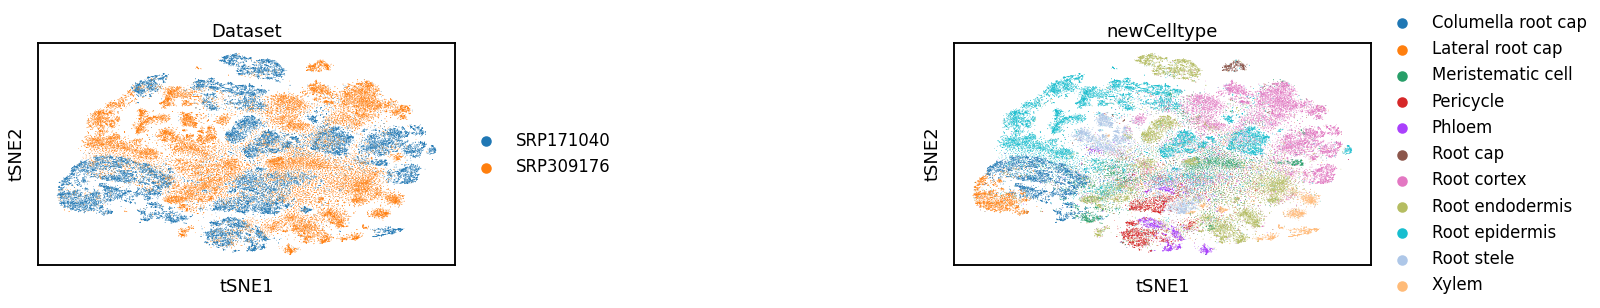

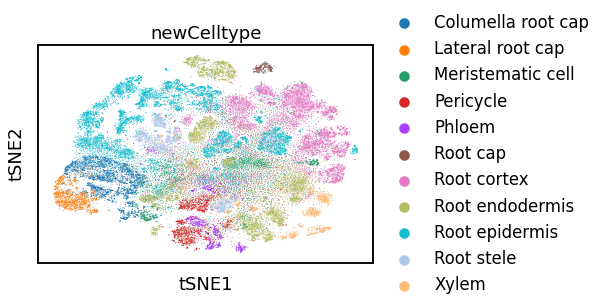

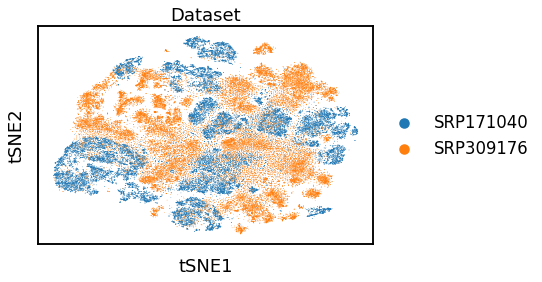

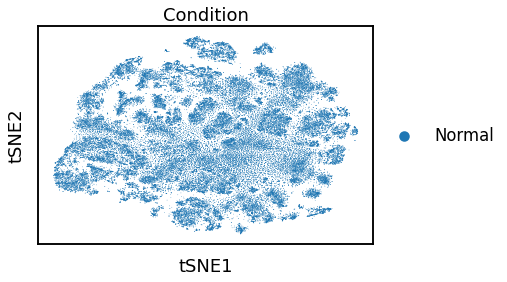

In [14]:
use_rep_name = "X_scmGPT_0"
# sc.tl.tsne(adata_mod1, use_rep=use_rep_name)
sc.pl.tsne(adata_mod1, color=["Dataset", "newCelltype"], wspace=1,save= data_name + use_rep_name + '_newCelltype_tsne_plot.pdf')
sc.pl.tsne(adata_mod1, color=["newCelltype"], wspace=1,save= data_name + use_rep_name + 'newCelltype_tsne_plot.pdf')
sc.pl.tsne(adata_mod1, color=["Dataset"], wspace=1,save= data_name + use_rep_name + 'experiments_tsne_plot.pdf')
sc.pl.tsne(adata_mod1, color=["Condition"], wspace=1,save= data_name + use_rep_name + 'Condition_tsne_plot.pdf')

In [15]:
adata_mod1_new.obs["Dataset"]

SRX5074330@@_AAACCTGAGACAGACC-1-0-1     SRP171040
SRX5074330@@_AAACCTGAGATCCGAG-1-0-1     SRP171040
SRX5074330@@_AAACCTGAGTGTGAAT-1-0-1     SRP171040
SRX5074330@@_AAACCTGCAAAGAATC-1-0-1     SRP171040
SRX5074330@@_AAACCTGCAAAGGAAG-1-0-1     SRP171040
                                          ...    
SRX10234835@@_TTTGTTGGTGGGATTG-1-1-1    SRP309176
SRX10234835@@_TTTGTTGGTGGGTCAA-1-1-1    SRP309176
SRX10234835@@_TTTGTTGTCCCTTGTG-1-1-1    SRP309176
SRX10234835@@_TTTGTTGTCTGAATGC-1-1-1    SRP309176
SRX10234835@@_TTTGTTGTCTGCGGGT-1-1-1    SRP309176
Name: Dataset, Length: 71222, dtype: category
Categories (2, object): ['SRP171040', 'SRP309176']

In [16]:
adata_mod1_new.obs["Celltype"].value_counts()

Celltype
Root cortex           13400
Root endodermis       12973
Root hair              7884
Columella root cap     5640
Root epidermis         5287
Non-hair               4242
Root stele             4230
Meristematic cell      4116
Pericycle              4005
Phloem                 2596
Lateral root cap       2537
Protoxylem             1526
Xylem                  1030
Root cap                808
Metaxylem               521
Stem cell niche         427
Name: count, dtype: int64

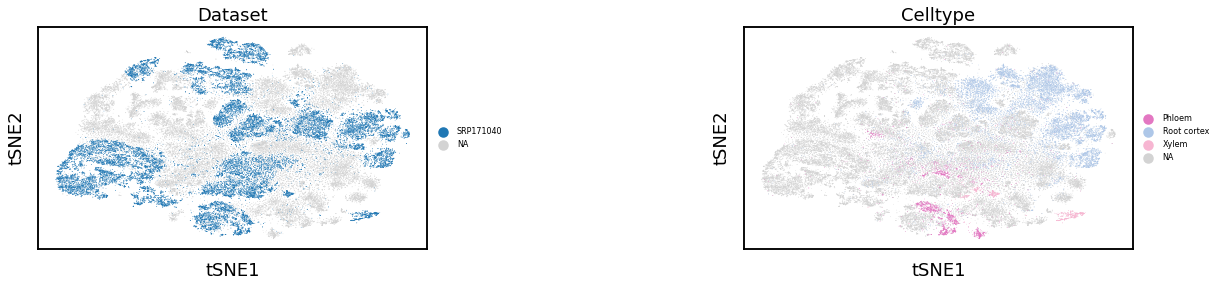

In [17]:
sc.pl.tsne(adata_mod1, color=["Dataset", "Celltype"],groups=['SRP171040',
                                                                 'Root hair'
                                                                    'Non-hair'
                                                                    'Meristematic cell',
                                                                    'Xylem',
                                                                    'Phloem',
                                                                    'Root cortex',
                                                                   ], legend_fontsize=8, wspace=0.65
          ,save= data_name + use_rep_name + 'experiments_tsne_plot_konwn.pdf')
#'Root epidermis',

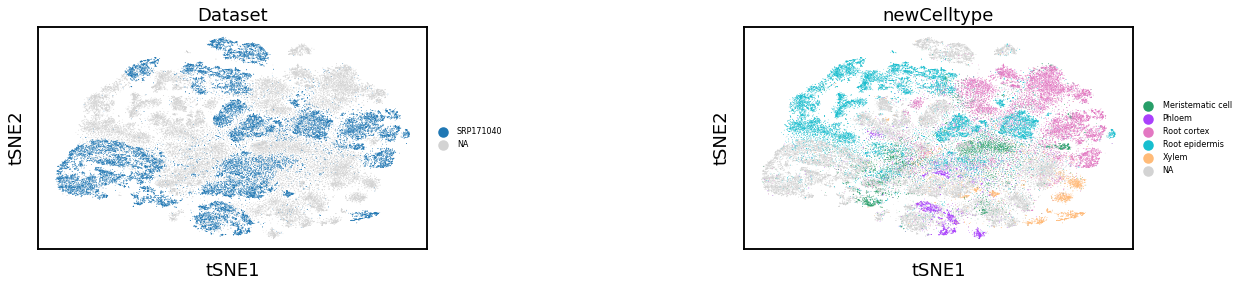

In [18]:
sc.pl.tsne(adata_mod1_new, color=["Dataset", "newCelltype"],groups=['SRP171040',
                                                                    'Root epidermis',
                                                                    'Meristematic cell',
                                                                    'Xylem',
                                                                    'Phloem',
                                                                    'Root cortex',
                                                                   ], legend_fontsize=8, wspace=0.65
          ,save= data_name + use_rep_name + 'experiments_tsne_plot_konwn.pdf')
#'Root epidermis',

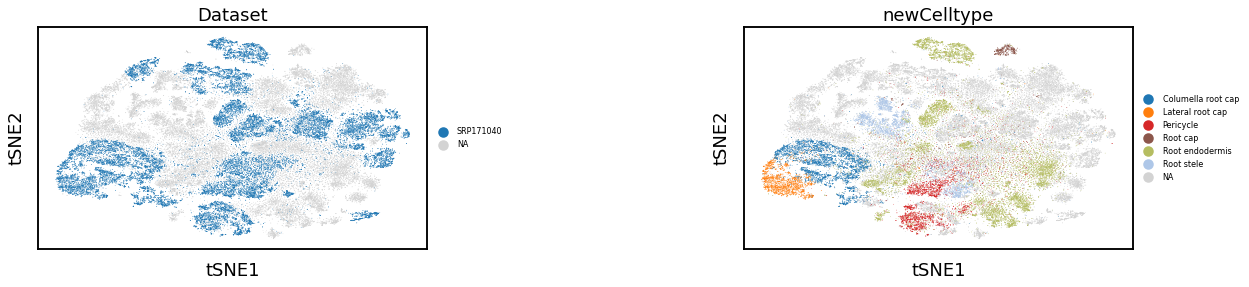

In [19]:
sc.pl.tsne(adata_mod1_new, color=["Dataset", "newCelltype"],groups=['SRP171040',
                                                                    'Root endodermis',
                                                                    'Root stele',
                                                                    'Columella root cap','Lateral root cap','Root cap',
                                                                    'Pericycle'
                                                                   ], legend_fontsize=8, wspace=0.65
          ,save= data_name + use_rep_name + 'experiments_tsne_plot_unkonwn.pdf')
#'Root epidermis',

In [20]:
adata_mod1_new.obs["newCelltype2"] = adata_mod1_new.obs["Celltype"]
# adata_mod1_new.obs["newCelltype"].replace(to_replace='Root hair', value='Root epidermis', inplace=True)
# adata_mod1_new.obs["newCelltype"].replace(to_replace='Non-hair', value='Root epidermis', inplace=True)
adata_mod1_new.obs["newCelltype2"].replace(to_replace='Stem cell niche', value='Meristematic cell', inplace=True)
# adata_mod1_new.obs["newCelltype2"].replace(to_replace='Protoxylem', value='Xylem', inplace=True)
# adata_mod1_new.obs["newCelltype2"].replace(to_replace='Metaxylem', value='Xylem', inplace=True)
adata_mod1_new.obs["newCelltype2"].value_counts()

C:\Users\xumuzhi\AppData\Local\Temp\ipykernel_44476\1684292163.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  adata_mod1_new.obs["newCelltype2"].replace(to_replace='Stem cell niche', value='Meristematic cell', inplace=True)
C:\Users\xumuzhi\AppData\Local\Temp\ipykernel_44476\1684292163.py:4: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.re

newCelltype2
Root cortex           13400
Root endodermis       12973
Root hair              7884
Columella root cap     5640
Root epidermis         5287
Meristematic cell      4543
Non-hair               4242
Root stele             4230
Pericycle              4005
Phloem                 2596
Lateral root cap       2537
Protoxylem             1526
Xylem                  1030
Root cap                808
Metaxylem               521
Name: count, dtype: int64

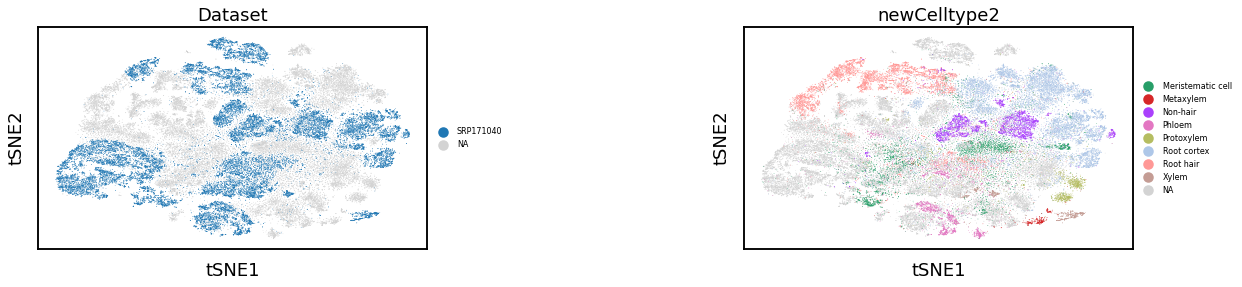

In [21]:
sc.pl.tsne(adata_mod1_new, color=["Dataset", "newCelltype2"],groups=['SRP171040',
                                                                    'Root hair','Non-hair',
                                                                    'Meristematic cell',
                                                                    'Xylem','Protoxylem','Metaxylem',
                                                                    'Phloem',
                                                                    'Root cortex',
                                                                   ], legend_fontsize=8, wspace=0.65
          ,save= data_name + use_rep_name + 'experiments_tsne_plot_konwn.pdf')
#'Root epidermis',

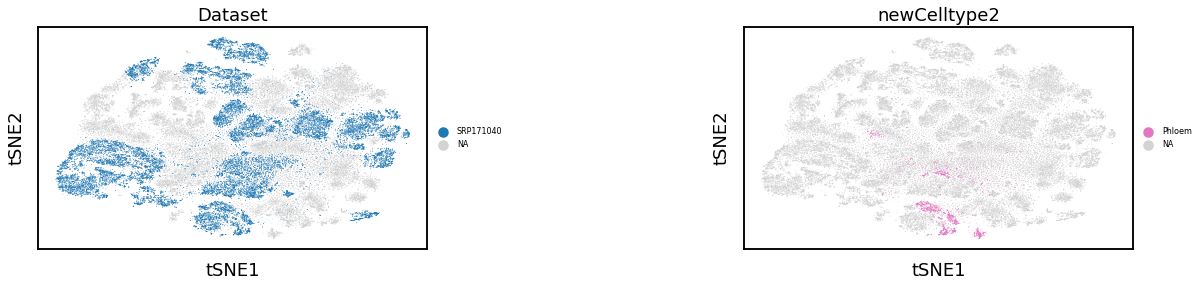

In [22]:
sc.pl.tsne(adata_mod1_new, color=["Dataset", "newCelltype2"],groups=['SRP171040',

                                                                    'Phloem',

                                                                   ], legend_fontsize=8, wspace=0.65
          ,save= data_name + use_rep_name + 'experiments_tsne_plot_konwn.pdf')
#'Root epidermis',

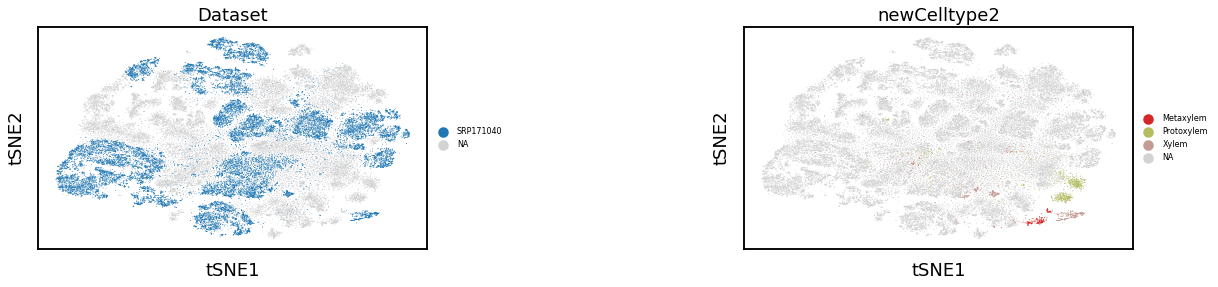

In [23]:
sc.pl.tsne(adata_mod1_new, color=["Dataset", "newCelltype2"],groups=['SRP171040',

                                                                    'Xylem','Protoxylem','Metaxylem',

                                                                   ], legend_fontsize=8, wspace=0.65
          ,save= data_name + use_rep_name + 'experiments_tsne_plot_konwn.pdf')
#'Root epidermis',

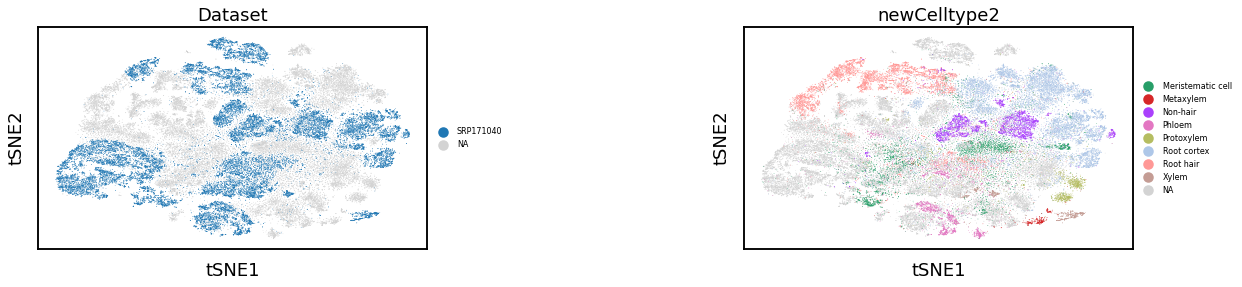

In [24]:
sc.pl.tsne(adata_mod1_new, color=["Dataset", "newCelltype2"],groups=['SRP171040',
                                                                    'Root hair','Non-hair',
                                                                    'Meristematic cell',
                                                                    'Xylem','Protoxylem','Metaxylem',
                                                                    'Phloem',
                                                                    'Root cortex',
                                                                   ], legend_fontsize=8, wspace=0.65
          ,save= data_name + use_rep_name + 'experiments_tsne_plot_konwn.pdf')
#'Root epidermis',

In [25]:
adata_mod1_new.write("SRP332285_new_rice_SRP309176_filter_all.h5ad")

C:\D\software\conda3\lib\site-packages\h5py\_hl\attrs.py:103: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  self.create(name, data=value)
C:\D\software\conda3\lib\site-packages\h5py\_hl\filters.py:250: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  chunks = guess_chunk(shape, maxshape, dtype.itemsize)


In [1]:
import scanpy as sc

C:\D\software\conda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\D\software\conda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


In [2]:
data_name = "SRP332285_new_rice_SRP309176_filter_all"
adata_mod1_new = sc.read(data_name + ".h5ad")
adata_mod1_new

AnnData object with n_obs × n_vars = 71222 × 8000
    obs: 'Orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Percent.mt', 'Seurat_clusters', 'Celltype', 'Dataset', 'Tissue', 'Organ', 'Condition', 'Genotype', 'Libraries', 'ACE', 'batch', 'experiments', 'orig.ident', 'percent.mt', 'percent.cp', 'integrated_snn_res.0.5', 'seurat_clusters', 'CellType', 'RNA_snn_res.0.6', 'domain_id', 'silhouette_temp', 'newCelltype', 'newCelltype2'
    uns: 'Celltype_colors', 'Condition_colors', 'Dataset_colors', 'neighbors', 'newCelltype2_colors', 'newCelltype_colors', 'tsne'
    obsm: 'X_scmGPT_0', 'X_tsne', 'X_umap', 'emb_mod1s'
    obsp: 'connectivities', 'distances'

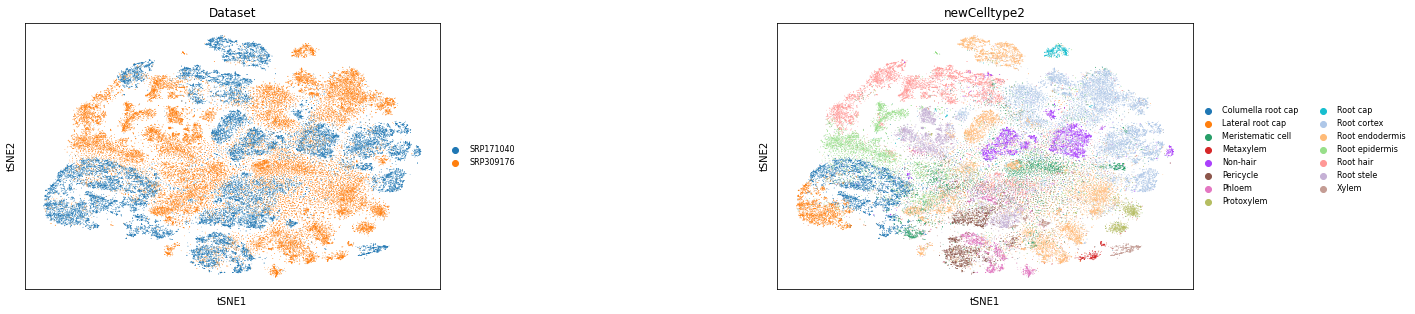

In [3]:
sc.pl.tsne(adata_mod1_new, color=["Dataset", "newCelltype2"],groups=[
                                                                   ], legend_fontsize=8, wspace=0.65
          ,save= data_name + 'tsne_plot_konwn.pdf')
#'Root epidermis',

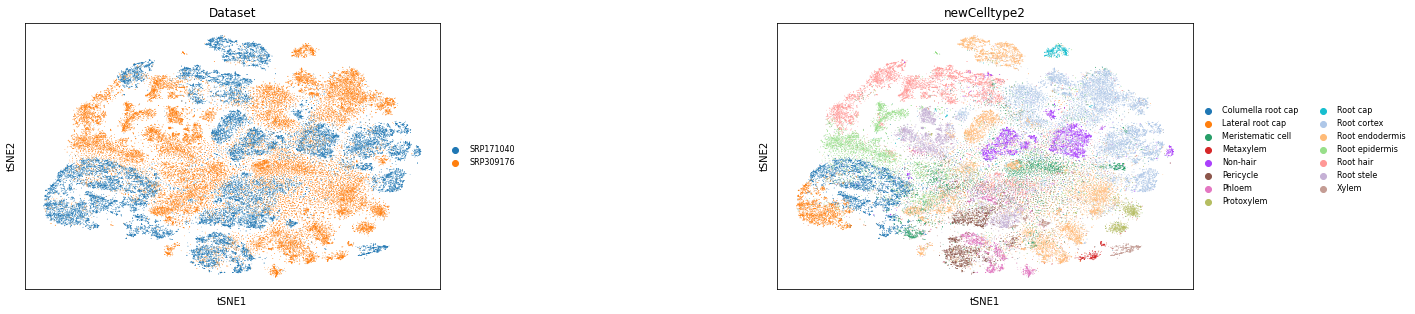

In [4]:
sc.pl.tsne(adata_mod1_new, color=["Dataset", "newCelltype2"],groups=[
                                                                   ], legend_fontsize=8, wspace=0.65
          ,save= data_name + 'tsne_plot_konwn.pdf')
#'Root epidermis',

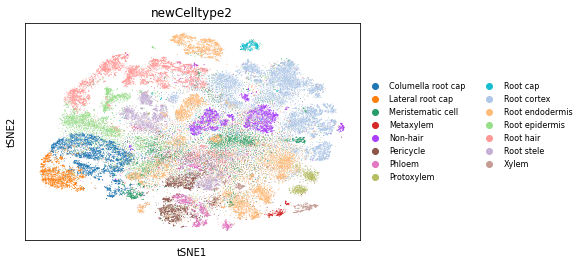

In [5]:

sc.pl.tsne(adata_mod1_new, color=["newCelltype2"],groups=[
                                                                   ], legend_fontsize=8, wspace=0.65
          ,save= data_name + 'newCelltype2_tsne_plot_konwn.pdf')
#'Root epidermis',

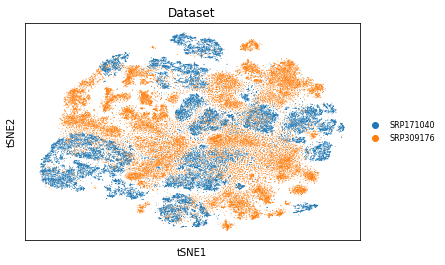

In [6]:


sc.pl.tsne(adata_mod1_new, color=["Dataset", ],groups=[
                                                                   ], legend_fontsize=8, wspace=0.65
          ,save= data_name + 'Dataset_tsne_plot_konwn.pdf')
#'Root epidermis',

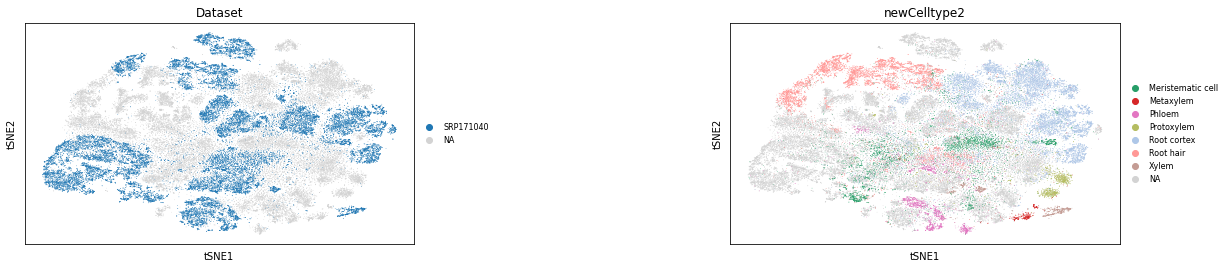

In [8]:
sc.pl.tsne(adata_mod1_new, color=["Dataset", "newCelltype2"],groups=['SRP171040',
                                                                    'Root hair',
                                                                    'Meristematic cell',
                                                                    'Xylem','Protoxylem','Metaxylem',
                                                                    'Phloem',
                                                                    'Root cortex',
                                                                   ], legend_fontsize=8, wspace=0.65
          ,save= data_name + 'tsne_plot_konwn.pdf')
#'Root epidermis',

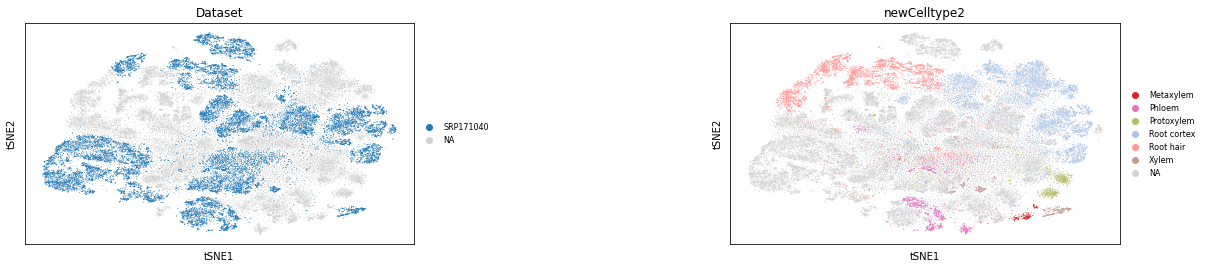

In [13]:
sc.pl.tsne(adata_mod1_new, color=["Dataset", "newCelltype2"],groups=['SRP171040',
                                                                    'Root hair','Root epidermis'
                                                                    'Meristematic cell',
                                                                    'Xylem','Protoxylem','Metaxylem',
                                                                    'Phloem',
                                                                    'Root cortex',
                                                                   ], legend_fontsize=8, wspace=0.65
          ,save= data_name + 'tsne_plot_konwn2.pdf')
#'Root epidermis',

In [15]:
adata_mod1_new.obs["newCelltype3"] = adata_mod1_new.obs["newCelltype2"]# .value_counts()

In [17]:
adata_mod1_new.obs["newCelltype3"].value_counts()

newCelltype3
Root cortex           13400
Root endodermis       12973
Root hair              7884
Columella root cap     5640
Root epidermis         5287
Meristematic cell      4543
Non-hair               4242
Root stele             4230
Pericycle              4005
Phloem                 2596
Lateral root cap       2537
Protoxylem             1526
Xylem                  1030
Root cap                808
Metaxylem               521
Name: count, dtype: int64

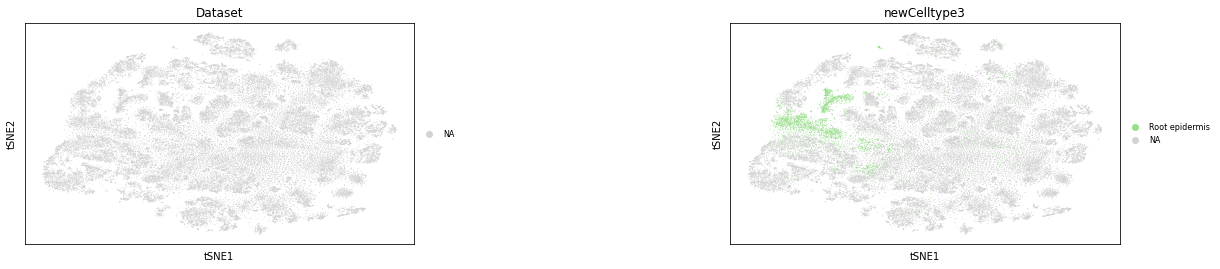

In [19]:
sc.pl.tsne(adata_mod1_new, color=["Dataset", "newCelltype3"],groups=['SRP171040',
                                                                    'Root hair','Root epidermis'
                                                                    'Meristematic cell',
                                                                    'Xylem','Protoxylem','Metaxylem',
                                                                    'Phloem',
                                                                    'Root cortex',
                                                                     ], legend_fontsize=8, wspace=0.65
          ,save= data_name + 'tsne_plot_konwn3.pdf')
#'Root epidermis',

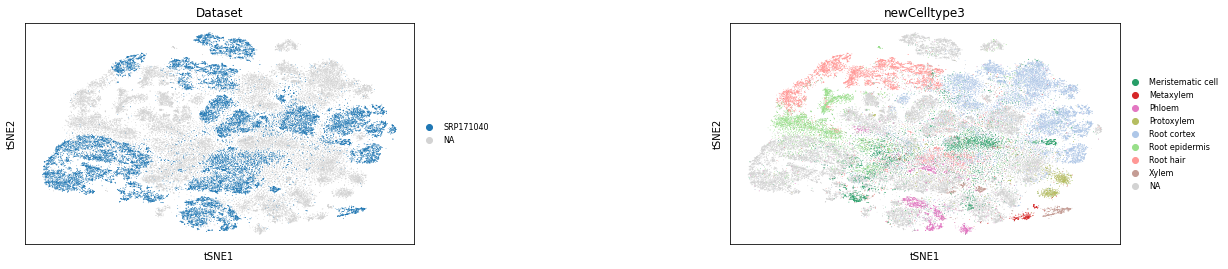

In [23]:
sc.pl.tsne(adata_mod1_new, color=["Dataset", "newCelltype3"],groups=['SRP171040',
                                                                    'Root hair','Root epidermis',
                                                                    'Meristematic cell',
                                                                    'Xylem','Protoxylem','Metaxylem',
                                                                    'Phloem',
                                                                    'Root cortex',
                                                                   ], legend_fontsize=8, wspace=0.65
          ,save= data_name + 'tsne_plot_konwn3.pdf')
#'Root epidermis',

In [14]:
adata_mod1_new.obs["newCelltype2"].value_counts()

newCelltype2
Root cortex           13400
Root endodermis       12973
Root hair              7884
Columella root cap     5640
Root epidermis         5287
Meristematic cell      4543
Non-hair               4242
Root stele             4230
Pericycle              4005
Phloem                 2596
Lateral root cap       2537
Protoxylem             1526
Xylem                  1030
Root cap                808
Metaxylem               521
Name: count, dtype: int64

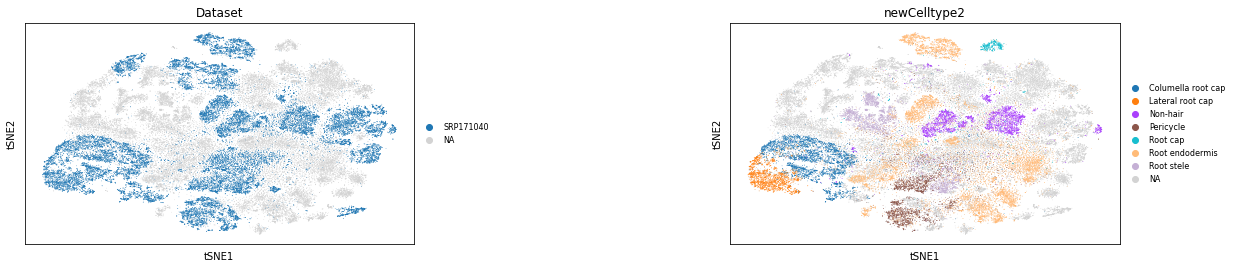

In [25]:
sc.pl.tsne(adata_mod1_new, color=["Dataset", "newCelltype2"],groups=['SRP171040',
                                                                    'Root endodermis',
                                                                     'Non-hair',
                                                                    'Root stele',
                                                                    'Columella root cap','Lateral root cap','Root cap',
                                                                    'Pericycle'
                                                                   ], legend_fontsize=8, wspace=0.65
          ,save= data_name + 'tsne_plot_unkonwn.pdf')
#'Root epidermis',

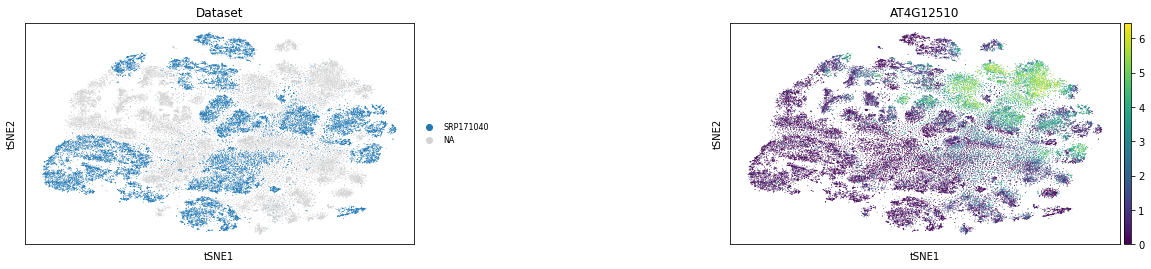

In [11]:
color_name = "AT4G12510"
sc.pl.tsne(adata_mod1_new, color=["Dataset",color_name],groups=['SRP171040',
                                                ], legend_fontsize=8, wspace=0.65
          ,save= data_name+ "_" + color_name + '_tsne_plot_konwn.pdf')


In [4]:
adata_mod1_new

AnnData object with n_obs × n_vars = 71222 × 8000
    obs: 'Orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Percent.mt', 'Seurat_clusters', 'Celltype', 'Dataset', 'Tissue', 'Organ', 'Condition', 'Genotype', 'Libraries', 'ACE', 'batch', 'experiments', 'orig.ident', 'percent.mt', 'percent.cp', 'integrated_snn_res.0.5', 'seurat_clusters', 'CellType', 'RNA_snn_res.0.6', 'domain_id', 'silhouette_temp', 'newCelltype', 'newCelltype2'
    uns: 'Celltype_colors', 'Condition_colors', 'Dataset_colors', 'neighbors', 'newCelltype2_colors', 'newCelltype_colors', 'tsne'
    obsm: 'X_scmGPT_0', 'X_tsne', 'X_umap', 'emb_mod1s'
    obsp: 'connectivities', 'distances'

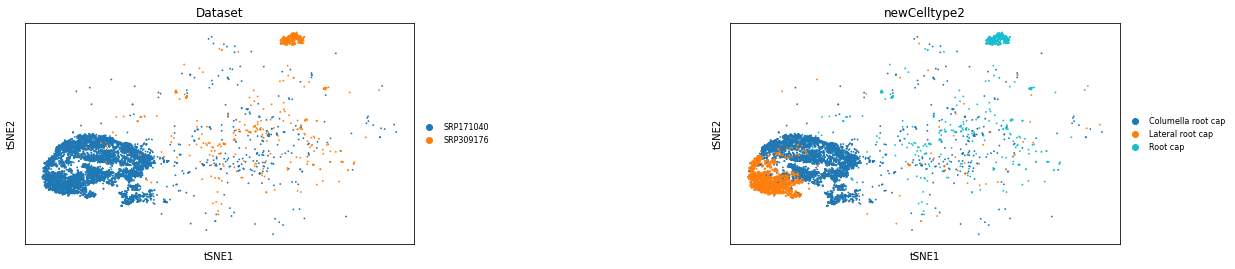

In [37]:
adata_Root_cap = adata_mod1_new[adata_mod1_new.obs["newCelltype2"].isin(["Columella root cap",
                                                                        "Lateral root cap",
                                                                        "Root cap"])]

sc.pl.tsne(adata_Root_cap, color=["Dataset","newCelltype2"],groups=['SRP171040','SRP309176',"Columella root cap",
                                                    "Lateral root cap","Root cap"
                                                    ], 
           legend_fontsize=8, wspace=0.65,
           save= data_name+ "_Root_cap_" + '_tsne_plot.pdf')

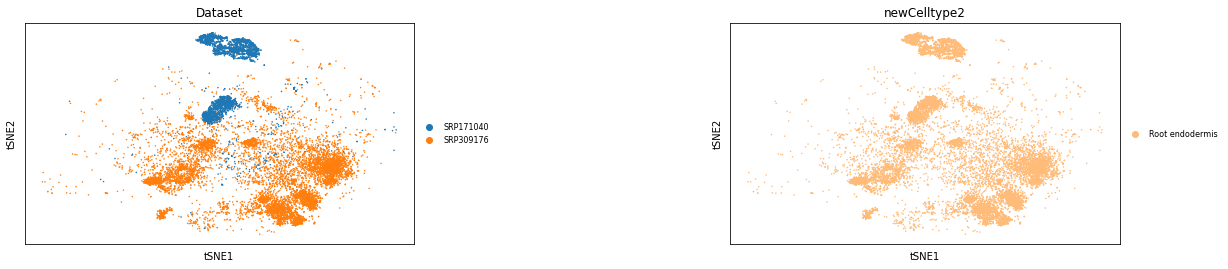

In [36]:
adata_Root_cap = adata_mod1_new[adata_mod1_new.obs["newCelltype2"].isin(["Root endodermis"])]

sc.pl.tsne(adata_Root_cap, color=["Dataset","newCelltype2"],groups=['SRP171040','SRP309176',"Root endodermis"
                                                    ], 
           legend_fontsize=8, wspace=0.65,
           save= data_name+ "_Root_endodermis_" + '_tsne_plot.pdf')

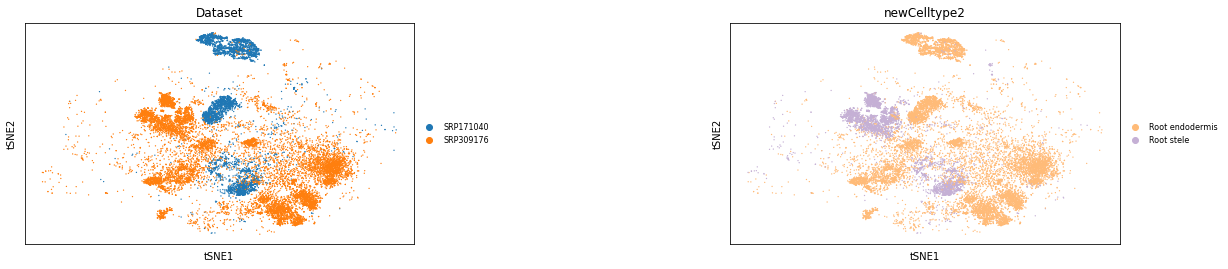

In [47]:
adata_Root_cap = adata_mod1_new[adata_mod1_new.obs["newCelltype2"].isin(["Root stele","Root endodermis"])]

sc.pl.tsne(adata_Root_cap, color=["Dataset","newCelltype2"],groups=['SRP171040',"Root stele",
                                                                    'SRP309176',"Root endodermis"
                                                    ], 
           legend_fontsize=8, wspace=0.65,
           save= data_name+ "_Root_endodermis_" + '_tsne_plot.pdf')

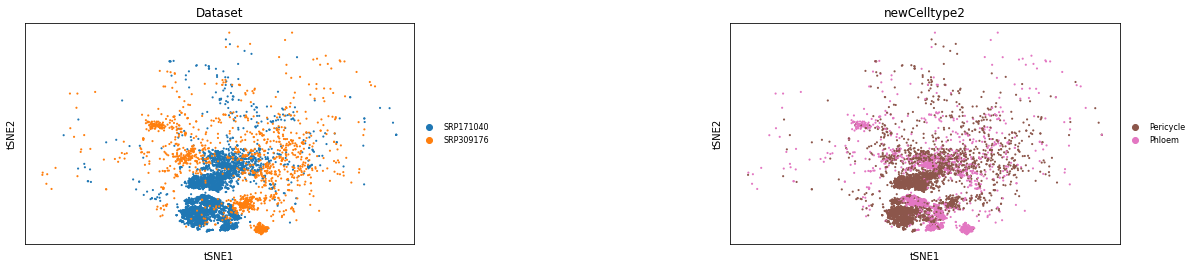

In [40]:
adata_Root_cap = adata_mod1_new[adata_mod1_new.obs["newCelltype2"].isin(["Pericycle","Phloem"])]

sc.pl.tsne(adata_Root_cap, color=["Dataset","newCelltype2"],groups=['SRP171040','SRP309176',"Pericycle","Phloem"
                                                    ], 
           legend_fontsize=8, wspace=0.65,
           save= data_name+ "_Pericycle_" + '_tsne_plot.pdf')

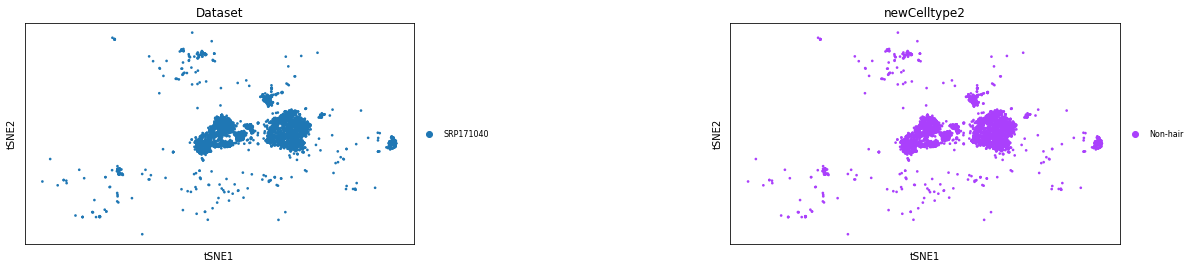

In [33]:
adata_Root_cap = adata_mod1_new[adata_mod1_new.obs["newCelltype2"].isin(["Non-hair"])]

sc.pl.tsne(adata_Root_cap, color=["Dataset","newCelltype2"],groups=['SRP171040','SRP309176',"Non-hair"
                                                    ], 
           legend_fontsize=8, wspace=0.65,
           save= data_name+ "_Non_hair_" + '_tsne_plot.pdf')

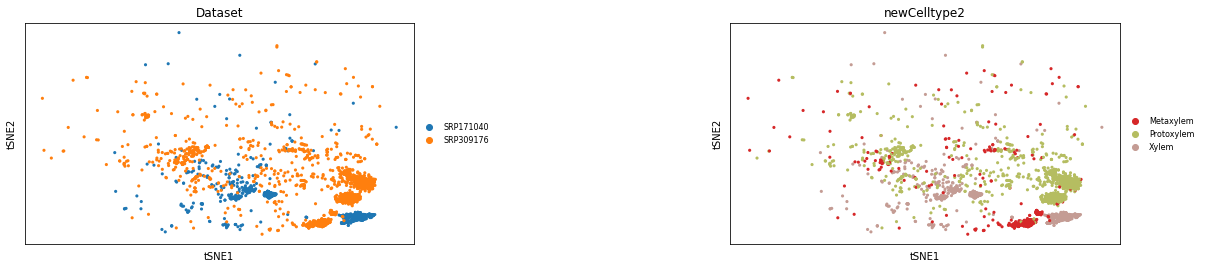

In [32]:
adata_Root_cap = adata_mod1_new[adata_mod1_new.obs["newCelltype2"].isin(["Metaxylem","Protoxylem",
                                                                        "Xylem"])]

sc.pl.tsne(adata_Root_cap, color=["Dataset","newCelltype2"],groups=['SRP171040','SRP309176',"Metaxylem","Protoxylem",
                                                                        "Xylem"], 
           legend_fontsize=8, wspace=0.65,
           save= data_name+ "_Xylem_" + '_tsne_plot.pdf')

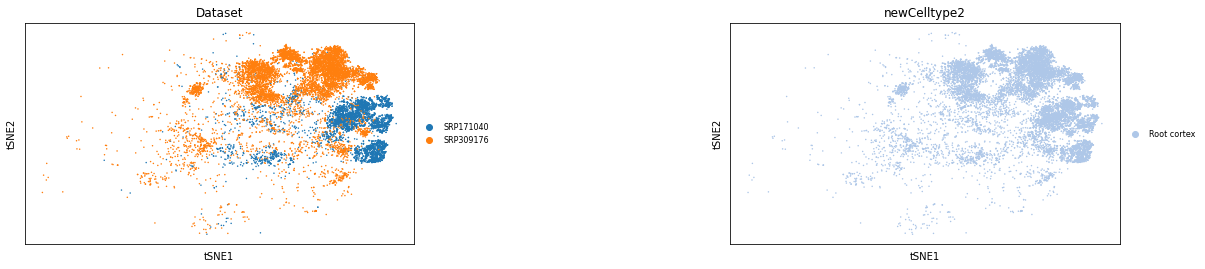

In [38]:
adata_Root_cap = adata_mod1_new[adata_mod1_new.obs["newCelltype2"].isin(["Root cortex"])]

sc.pl.tsne(adata_Root_cap, color=["Dataset","newCelltype2"],groups=['SRP171040','SRP309176',"Root cortex"], 
           legend_fontsize=8, wspace=0.65,
           save= data_name+ "_Root_cortex_" + '_tsne_plot.pdf')

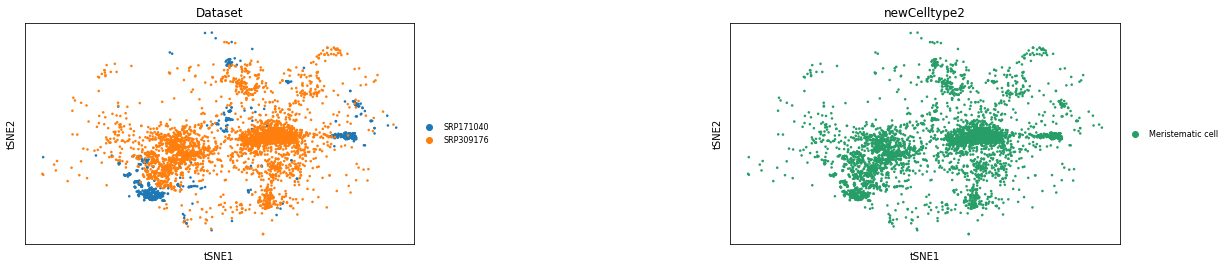

In [39]:
adata_Root_cap = adata_mod1_new[adata_mod1_new.obs["newCelltype2"].isin(["Meristematic cell"])]

sc.pl.tsne(adata_Root_cap, color=["Dataset","newCelltype2"],groups=['SRP171040','SRP309176',"Meristematic cell"], 
           legend_fontsize=8, wspace=0.65,
           save= data_name+ "_Meristematic_cell_" + '_tsne_plot.pdf')

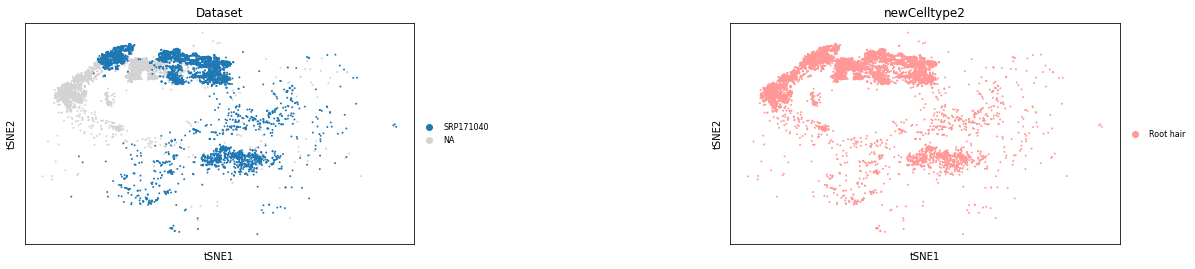

In [29]:
adata_Root_cap = adata_mod1_new[adata_mod1_new.obs["newCelltype2"].isin(["Root hair"])]

sc.pl.tsne(adata_Root_cap, color=["Dataset","newCelltype2"],groups=['SRP171040',"Root hair"], 
           legend_fontsize=8, wspace=0.65,
           save= data_name+ "_Root_hair_" + '_tsne_plot.pdf')

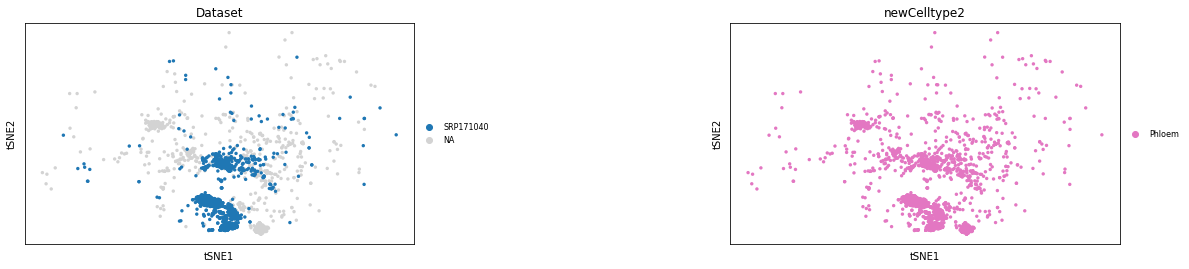

In [30]:
adata_Root_cap = adata_mod1_new[adata_mod1_new.obs["newCelltype2"].isin(["Phloem"])]

sc.pl.tsne(adata_Root_cap, color=["Dataset","newCelltype2"],groups=['SRP171040',"Phloem"], 
           legend_fontsize=8, wspace=0.65,
           save= data_name+ "_Phloem_" + '_tsne_plot.pdf')

In [48]:
adata_mod1_new

AnnData object with n_obs × n_vars = 71222 × 8000
    obs: 'Orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Percent.mt', 'Seurat_clusters', 'Celltype', 'Dataset', 'Tissue', 'Organ', 'Condition', 'Genotype', 'Libraries', 'ACE', 'batch', 'experiments', 'orig.ident', 'percent.mt', 'percent.cp', 'integrated_snn_res.0.5', 'seurat_clusters', 'CellType', 'RNA_snn_res.0.6', 'domain_id', 'silhouette_temp', 'newCelltype', 'newCelltype2'
    uns: 'Celltype_colors', 'Condition_colors', 'Dataset_colors', 'neighbors', 'newCelltype2_colors', 'newCelltype_colors', 'tsne'
    obsm: 'X_scmGPT_0', 'X_tsne', 'X_umap', 'emb_mod1s'
    obsp: 'connectivities', 'distances'

In [53]:
adata_mod1_new_05SRP171040 = adata_mod1_new[adata_mod1_new.obs["Dataset"].isin(["SRP171040"])]
adata_mod1_new_05SRP171040

View of AnnData object with n_obs × n_vars = 33956 × 8000
    obs: 'Orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Percent.mt', 'Seurat_clusters', 'Celltype', 'Dataset', 'Tissue', 'Organ', 'Condition', 'Genotype', 'Libraries', 'ACE', 'batch', 'experiments', 'orig.ident', 'percent.mt', 'percent.cp', 'integrated_snn_res.0.5', 'seurat_clusters', 'CellType', 'RNA_snn_res.0.6', 'domain_id', 'silhouette_temp', 'newCelltype', 'newCelltype2'
    uns: 'Celltype_colors', 'Condition_colors', 'Dataset_colors', 'neighbors', 'newCelltype2_colors', 'newCelltype_colors', 'tsne'
    obsm: 'X_scmGPT_0', 'X_tsne', 'X_umap', 'emb_mod1s'
    obsp: 'connectivities', 'distances'

In [54]:
adata_mod1_new_SRP309176 = adata_mod1_new[adata_mod1_new.obs["Dataset"].isin(["SRP309176"])]
adata_mod1_new_SRP309176

View of AnnData object with n_obs × n_vars = 37266 × 8000
    obs: 'Orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Percent.mt', 'Seurat_clusters', 'Celltype', 'Dataset', 'Tissue', 'Organ', 'Condition', 'Genotype', 'Libraries', 'ACE', 'batch', 'experiments', 'orig.ident', 'percent.mt', 'percent.cp', 'integrated_snn_res.0.5', 'seurat_clusters', 'CellType', 'RNA_snn_res.0.6', 'domain_id', 'silhouette_temp', 'newCelltype', 'newCelltype2'
    uns: 'Celltype_colors', 'Condition_colors', 'Dataset_colors', 'neighbors', 'newCelltype2_colors', 'newCelltype_colors', 'tsne'
    obsm: 'X_scmGPT_0', 'X_tsne', 'X_umap', 'emb_mod1s'
    obsp: 'connectivities', 'distances'

In [59]:
adata_mod1_new_05SRP171040.obsm["X_tsne"]

ArrayView([[-13.606748, -76.83652 ],
           [-12.147297, -75.69412 ],
           [-39.932358, -51.031597],
           ...,
           [-69.56828 , -16.458952],
           [-52.54132 , -21.868067],
           [-50.430172, -23.342941]], dtype=float32)

In [55]:
adata_mod1_new_05SRP171040.obs["newCelltype2"].value_counts()

newCelltype2
Columella root cap    5640
Root cortex           4747
Root hair             4743
Non-hair              4242
Root endodermis       3668
Pericycle             3232
Lateral root cap      2537
Phloem                1753
Root stele            1367
Xylem                 1030
Meristematic cell      997
Name: count, dtype: int64

In [56]:
adata_mod1_new_SRP309176.obs["newCelltype2"].value_counts()

newCelltype2
Root endodermis      9305
Root cortex          8653
Root epidermis       5287
Meristematic cell    3546
Root hair            3141
Root stele           2863
Protoxylem           1526
Phloem                843
Root cap              808
Pericycle             773
Metaxylem             521
Name: count, dtype: int64

In [60]:

distances = sc.tl.compute_distance_to_group(adata_mod1_new_SRP309176, adata_mod1_new_05SRP171040, 
                                            groupby='newCelltype2')


AttributeError: compute_distance_to_group

In [66]:
adata_mod1_new.obs["newCelltype2"].value_counts()

newCelltype2
Root cortex           13400
Root endodermis       12973
Root hair              7884
Columella root cap     5640
Root epidermis         5287
Meristematic cell      4543
Non-hair               4242
Root stele             4230
Pericycle              4005
Phloem                 2596
Lateral root cap       2537
Protoxylem             1526
Xylem                  1030
Root cap                808
Metaxylem               521
Name: count, dtype: int64

In [62]:
adata1 = adata_mod1_new_SRP309176
adata2 = adata_mod1_new_05SRP171040

In [69]:
centroids_adata1

{'Meristematic cell': array([0.0000000e+00, 6.0979668e-03, 0.0000000e+00, ..., 4.0133506e-05,
        0.0000000e+00, 5.6483722e-03], dtype=float32),
 'Root hair': array([0.        , 0.01130054, 0.        , ..., 0.        , 0.        ,
        0.00285209], dtype=float32),
 'Root epidermis': array([0.        , 0.00743031, 0.        , ..., 0.00051286, 0.        ,
        0.00121515], dtype=float32),
 'Root cortex': array([0.        , 0.00409322, 0.        , ..., 0.00013019, 0.        ,
        0.0034931 ], dtype=float32),
 'Protoxylem': array([0.        , 0.00296311, 0.        , ..., 0.        , 0.        ,
        0.00316062], dtype=float32),
 'Metaxylem': array([0.        , 0.02336427, 0.        , ..., 0.        , 0.        ,
        0.01417387], dtype=float32),
 'Root endodermis': array([0.        , 0.01011458, 0.        , ..., 0.00079648, 0.        ,
        0.01576564], dtype=float32),
 'Root stele': array([0.        , 0.01334366, 0.        , ..., 0.0044566 , 0.        ,
        0.01

In [70]:
centroids_adata2

{'Pericycle': array([2.7672678e-01, 4.3399902e-03, 1.2790188e-01, ..., 1.0853578e-04,
        1.1174842e+00, 6.0478903e-02], dtype=float32),
 'Meristematic cell': array([0.17827278, 0.01434185, 0.00277008, ..., 0.        , 0.6168337 ,
        0.14642854], dtype=float32),
 'Root endodermis': array([2.0252560e-01, 1.7641444e-02, 2.4191642e-03, ..., 9.5661708e-05,
        8.4751815e-01, 6.1257072e-02], dtype=float32),
 'Root hair': array([0.06447555, 0.00199691, 0.00222411, ..., 0.00065589, 0.5268667 ,
        0.2532792 ], dtype=float32),
 'Columella root cap': array([2.4247715e-02, 2.5544062e-03, 1.1732271e-03, ..., 0.0000000e+00,
        1.6544431e+00, 4.0574800e-02], dtype=float32),
 'Phloem': array([0.46077016, 0.01041186, 0.01371978, ..., 0.0139137 , 1.7556864 ,
        0.09146099], dtype=float32),
 'Root cortex': array([0.12588567, 0.00503027, 0.00270069, ..., 0.        , 0.33818173,
        0.16620938], dtype=float32),
 'Xylem': array([1.01793915e-01, 9.40599199e-03, 1.98597893e-01

In [63]:
import scanpy as sc
import numpy as np
from scipy.spatial.distance import pdist, squareform

# 假设adata1和adata2是两个已经加载的AnnData对象
# 假设'cell_type'是每个细胞类型的列名

# 计算每个细胞类型的代表性细胞的X_tsne坐标的平均值
def get_centroid(adata, cell_type):
    return adata[adata.obs['newCelltype2'] == cell_type, :].X.toarray().mean(axis=0)

centroids_adata1 = {cell_type: get_centroid(adata1, cell_type) for cell_type 
                    in adata1.obs['newCelltype2'].unique()}

centroids_adata2 = {cell_type: get_centroid(adata2, cell_type) for cell_type 
                    in adata2.obs['newCelltype2'].unique()}

# 将代表性细胞的坐标转换为一个numpy数组
centroids_adata1_array = np.array([centroids_adata1[cell_type] for cell_type in centroids_adata1])
centroids_adata2_array = np.array([centroids_adata2[cell_type] for cell_type in centroids_adata2])

# 计算两个数据集中代表性细胞之间的距离矩阵
distances_adata1_to_adata2 = squareform(pdist(centroids_adata1_array, 'euclidean'))
distances_adata2_to_adata1 = squareform(pdist(centroids_adata2_array, 'euclidean'))

# 现在你可以分析这些距离矩阵了，比如计算平均距离
average_distance_adata1_to_adata2 = np.mean(distances_adata1_to_adata2)
average_distance_adata2_to_adata1 = np.mean(distances_adata2_to_adata1)

print(f"Average distance from adata1 to adata2: {average_distance_adata1_to_adata2}")
print(f"Average distance from adata2 to adata1: {average_distance_adata2_to_adata1}")

Average distance from adata1 to adata2: 9.439478090280284
Average distance from adata2 to adata1: 19.221557277558446


In [75]:
centroids_adata1_array.shape

(11, 8000)

In [73]:
distances_adata1_to_adata2

array([[ 0.        ,  9.54290046,  7.38961107,  7.30825002,  8.7308253 ,
         9.9428517 ,  4.21808333, 12.15462408, 11.1800985 ,  7.46167233,
         6.5402027 ],
       [ 9.54290046,  0.        ,  6.777135  , 11.187952  , 12.05538739,
        12.66806596, 10.21522505, 11.8456799 , 13.37231689, 11.20323976,
        11.03576712],
       [ 7.38961107,  6.777135  ,  0.        ,  9.40073403, 10.76557286,
        11.63355943,  8.37971486,  9.50396152, 11.40655006,  9.63517184,
         9.28460095],
       [ 7.30825002, 11.187952  ,  9.40073403,  0.        , 10.74806006,
        11.22589308,  8.22521938, 12.60535396, 10.85241037, 10.24836963,
         9.80375506],
       [ 8.7308253 , 12.05538739, 10.76557286, 10.74806006,  0.        ,
        10.06746625,  8.93500347, 12.98104152, 11.61948369, 11.71847098,
         9.17685521],
       [ 9.9428517 , 12.66806596, 11.63355943, 11.22589308, 10.06746625,
         0.        , 10.120157  , 14.18007101, 14.11277164, 11.51459293,
        11.086

In [65]:
distances_adata1_to_adata2.shape

(11, 11)

In [68]:
distances_adata2_to_adata1.shape

(11, 11)

In [88]:
import scanpy as sc
import numpy as np
from scipy.spatial.distance import pdist, squareform

# 假设adata1和adata2是两个已经加载的AnnData对象
# 假设'cell_type'是每个细胞类型的列名

# 计算每个细胞类型的代表性细胞的X_tsne坐标的平均值
def get_centroid(adata, cell_type):
    return adata[adata.obs['newCelltype2'] == cell_type, :].obsm["X_tsne"].toarray().mean(axis=0)

centroids_adata1 = {cell_type: get_centroid(adata1, cell_type) for cell_type 
                    in adata1.obs['newCelltype2'].unique()}

centroids_adata2 = {cell_type: get_centroid(adata2, cell_type) for cell_type 
                    in adata2.obs['newCelltype2'].unique()}

# 将代表性细胞的坐标转换为一个numpy数组
centroids_adata1_array = np.array([centroids_adata1[cell_type] for cell_type in centroids_adata1])
centroids_adata2_array = np.array([centroids_adata2[cell_type] for cell_type in centroids_adata2])

# 计算两个数据集中代表性细胞之间的距离矩阵
distances_adata1_to_adata2 = squareform(pdist(centroids_adata1_array, 'euclidean'))
distances_adata2_to_adata1 = squareform(pdist(centroids_adata2_array, 'euclidean'))

# 现在你可以分析这些距离矩阵了，比如计算平均距离
average_distance_adata1_to_adata2 = np.mean(distances_adata1_to_adata2)
average_distance_adata2_to_adata1 = np.mean(distances_adata2_to_adata1)

print(f"Average distance from adata1 to adata2: {average_distance_adata1_to_adata2}")
print(f"Average distance from adata2 to adata1: {average_distance_adata2_to_adata1}")

Average distance from adata1 to adata2: 57.24019357515984
Average distance from adata2 to adata1: 63.97677482382454


In [90]:
from scipy.spatial.distance import cdist
distance_matrix = cdist(centroids_adata1_array, centroids_adata2_array, metric='euclidean')
distance_matrix

array([[ 40.51660288,  12.98798998,  66.19891154,  54.01922929,
         60.79675622,  44.21816721,  58.02201233,  54.52132583,
         32.52771012,  85.43453332,  25.43056918],
       [101.89074881,  84.34052224,  51.36188795,  35.19886935,
         62.65460671, 109.22260531, 115.50687045, 130.32902279,
         79.50920602,  82.45053941,  96.77818501],
       [ 69.40344003,  55.88139761,  62.07869347,  40.74099992,
         32.55380505,  77.0739715 , 102.17898636, 102.64228114,
         67.11077658,  57.09416808,  67.05936019],
       [ 96.00625918,  68.56771775,  40.00280335,  50.1264876 ,
        107.15023673,  97.98739221,  39.06609078,  89.44961361,
         24.40063256, 133.71344587,  78.13833085],
       [ 57.18919012,  46.40281183, 100.37610652,  95.94938848,
        104.57666038,  52.89301375,  40.78106565,  21.83256011,
         52.90979296, 125.56168764,  41.48978014],
       [ 45.36459168,  46.57824744, 115.04281306, 107.06796477,
        100.05834764,  38.79442798,  62.9

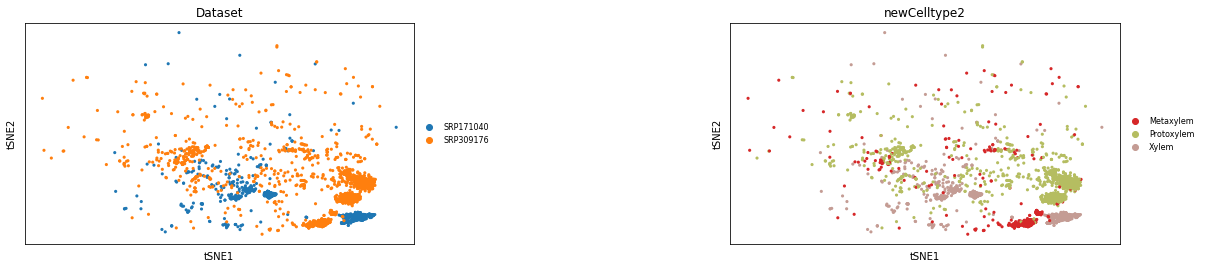

In [121]:
adata_Root_type = adata_mod1_new[adata_mod1_new.obs["newCelltype2"].isin(["Xylem",
                                                    "Metaxylem","Protoxylem",])]

sc.pl.tsne(adata_Root_type, color=["Dataset","newCelltype2"],groups=['SRP171040','SRP309176',
                                                    "Xylem",
                                                    "Metaxylem","Protoxylem",
                                                    ], 
           legend_fontsize=8, wspace=0.65,
           save= data_name+ "_Xylem_" + '_tsne_plot.pdf')

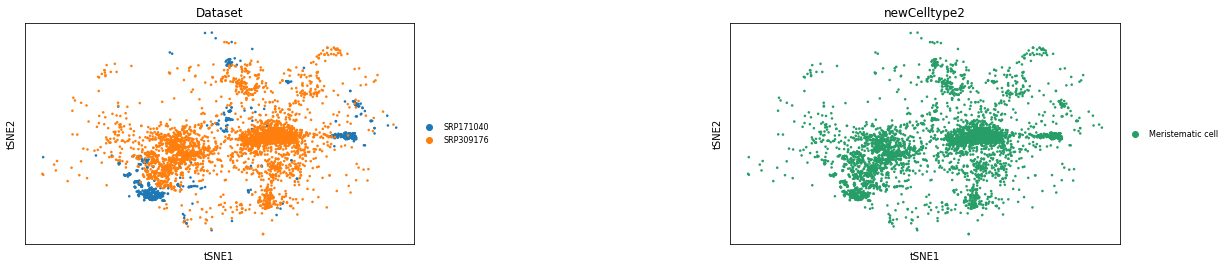

In [122]:
adata_Root_type = adata_mod1_new[adata_mod1_new.obs["newCelltype2"].isin(["Meristematic cell",
                                                    ])]

sc.pl.tsne(adata_Root_type, color=["Dataset","newCelltype2"],groups=['SRP171040','SRP309176',
"Meristematic cell",
                                                    ], 
           legend_fontsize=8, wspace=0.65,
           save= data_name+ "_Meristematic cell_" + '_tsne_plot.pdf')

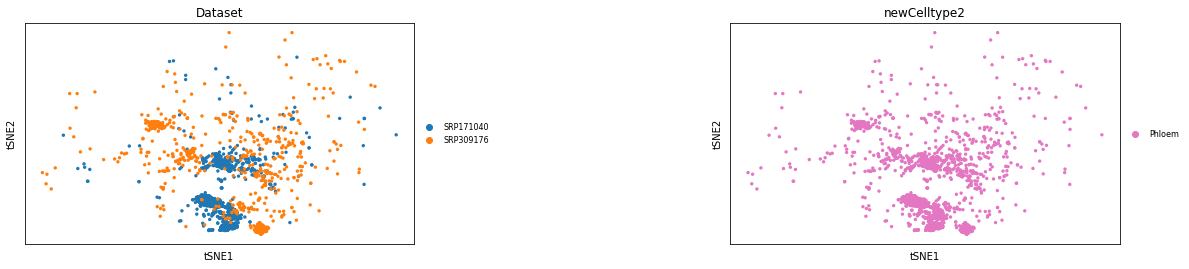

In [123]:
adata_Root_type = adata_mod1_new[adata_mod1_new.obs["newCelltype2"].isin(["Phloem",
                                                    ])]

sc.pl.tsne(adata_Root_type, color=["Dataset","newCelltype2"],groups=['SRP171040','SRP309176',
"Phloem",
                                                    ], 
           legend_fontsize=8, wspace=0.65,
           save= data_name+ "_Phloem_" + '_tsne_plot.pdf')

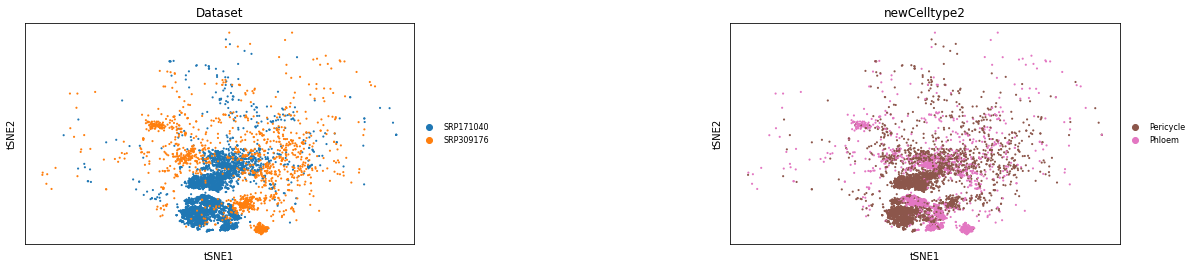

In [124]:
adata_Root_type = adata_mod1_new[adata_mod1_new.obs["newCelltype2"].isin(["Pericycle","Phloem"
                                                    ])]

sc.pl.tsne(adata_Root_type, color=["Dataset","newCelltype2"],groups=['SRP171040','SRP309176',
"Pericycle","Phloem",
                                                    ], 
           legend_fontsize=8, wspace=0.65,
           save= data_name+ "_Pericycle_" + '_tsne_plot.pdf')

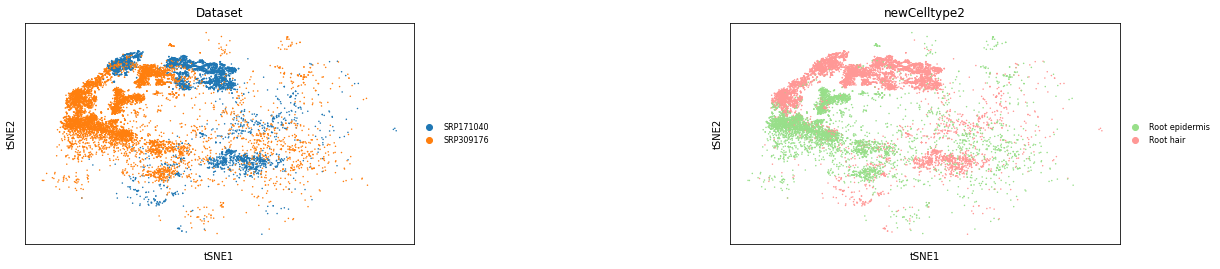

In [125]:
adata_Root_type = adata_mod1_new[adata_mod1_new.obs["newCelltype2"].isin(["Root hair","Root epidermis"
                                                    ])]

sc.pl.tsne(adata_Root_type, color=["Dataset","newCelltype2"],groups=['SRP171040','SRP309176',
"Root hair","Root epidermis"
                                                    ], 
           legend_fontsize=8, wspace=0.65,
           save= data_name+ "_Root_hair_" + '_tsne_plot.pdf')

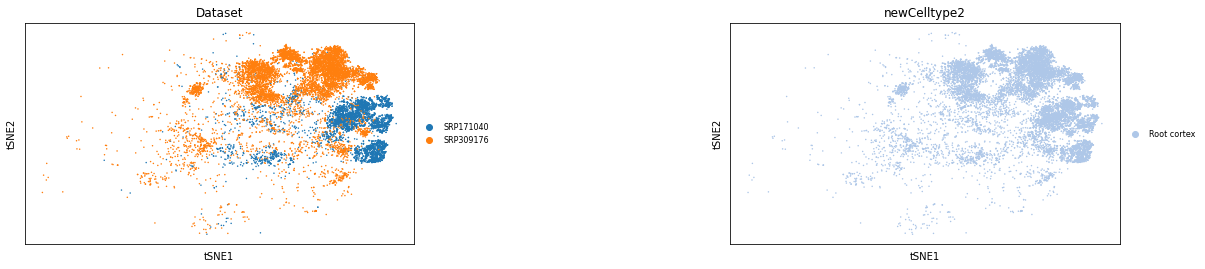

In [126]:
adata_Root_type = adata_mod1_new[adata_mod1_new.obs["newCelltype2"].isin(["Root cortex"
                                                    ])]

sc.pl.tsne(adata_Root_type, color=["Dataset","newCelltype2"],groups=['SRP171040','SRP309176',
"Root cortex"
                                                    ], 
           legend_fontsize=8, wspace=0.65,
           save= data_name+ "_Root_cortex_" + '_tsne_plot.pdf')

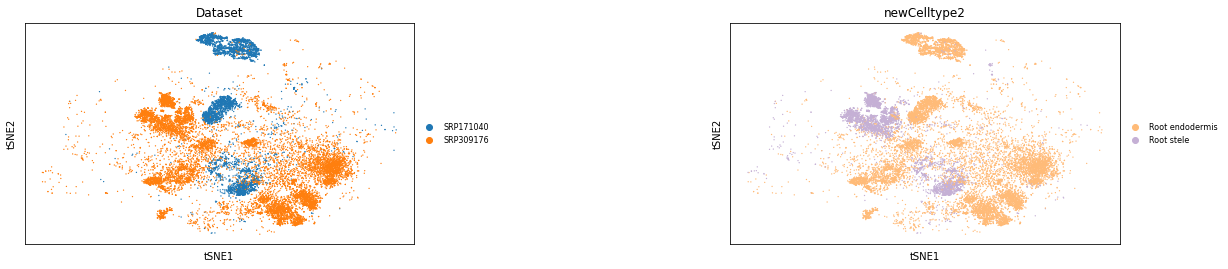

In [130]:
adata_Root_type = adata_mod1_new[adata_mod1_new.obs["newCelltype2"].isin(["Root stele","Root endodermis"
                                                    ])]

sc.pl.tsne(adata_Root_type, color=["Dataset","newCelltype2"],groups=['SRP171040','SRP309176',
"Root stele","Root endodermis"
                                                    ], 
           legend_fontsize=8, wspace=0.65,
           save= data_name+ "_Root_stele_" + '_tsne_plot.pdf')

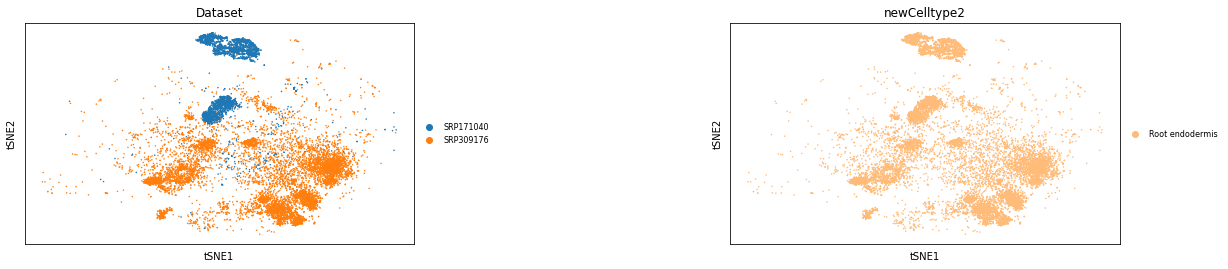

In [128]:
adata_Root_type = adata_mod1_new[adata_mod1_new.obs["newCelltype2"].isin(["Root endodermis"
                                                    ])]

sc.pl.tsne(adata_Root_type, color=["Dataset","newCelltype2"],groups=['SRP171040','SRP309176',
"Root endodermis"
                                                    ], 
           legend_fontsize=8, wspace=0.65,
           save= data_name+ "_Root_endodermis_" + '_tsne_plot.pdf')

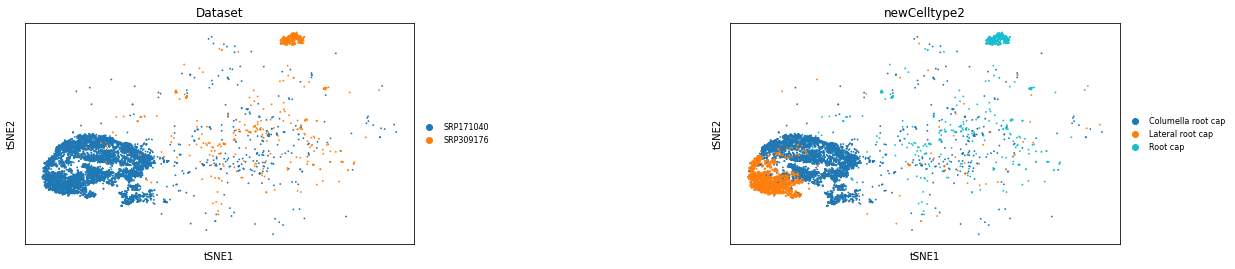

In [129]:
adata_Root_type = adata_mod1_new[adata_mod1_new.obs["newCelltype2"].isin(["Columella root cap",
                                                                          "Lateral root cap",
                                                                          "Root cap"
                                                    ])]

sc.pl.tsne(adata_Root_type, color=["Dataset","newCelltype2"],groups=['SRP171040','SRP309176',
"Columella root cap","Lateral root cap","Root cap"
                                                    ], 
           legend_fontsize=8, wspace=0.65,
           save= data_name+ "_Root_cap_" + '_tsne_plot.pdf')

In [103]:
# import scanpy as sc
# import numpy as np
# from scipy.spatial.distance import pdist, squareform

# # 假设 adata1 和 adata2 是两个已经加载的 AnnData 对象
# # 假设 'cell_type' 是每个细胞类型的列名

# # 函数：计算每个细胞类型的代表性细胞的 X_tsne 坐标的平均值
# def get_centroid(adata, cell_types):
#     centroids = {}
#     for cell_type in cell_types:
#         if cell_type in adata.obs['newCelltype2'].unique():
#             centroids[cell_type] = adata[adata.obs['newCelltype2'] == cell_type, :].obsm['X_tsne'].mean(axis=0)
#     return centroids

# # 获取两个数据集中每种细胞类型的代表性细胞坐标
# cell_types = adata1.obs['newCelltype2'].unique()
# centroids_adata1 = get_centroid(adata1, cell_types)
# centroids_adata2 = get_centroid(adata2, cell_types)

# # 将代表性细胞的坐标转换为 numpy 数组
# centroids_adata1_array = np.array([centroids_adata1[cell_type] for cell_type in centroids_adata1])
# centroids_adata2_array = np.array([centroids_adata2[cell_type] for cell_type in centroids_adata2])

# # 计算两个数据集中代表性细胞之间的距离矩阵
# distances_adata1_to_adata2 = squareform(pdist(centroids_adata1_array, 'euclidean'))
# distances_adata2_to_adata1 = squareform(pdist(centroids_adata2_array, 'euclidean'))

# # 打印出每行和每列代表的细胞类型
# print("Distance matrix from adata1 to adata2:")
# print("Rows: adata1 cell types")
# print("Columns: adata2 cell types")
# print(distances_adata1_to_adata2)

# print("\nDistance matrix from adata2 to adata1:")
# print("Rows: adata2 cell types")
# print("Columns: adata1 cell types")
# print(distances_adata2_to_adata1)

In [96]:
# use_rep_name = "X_scmGPT_0"
# sc.tl.tsne(adata_Root_cap, use_rep=use_rep_name)
# sc.pl.tsne(adata_Root_cap, color=["Dataset","newCelltype2"],groups=['SRP171040',"Columella root cap",
#                                                     "Lateral root cap","Root cap"
#                                                     ], 
#            legend_fontsize=8, wspace=0.65,
#            save= data_name+ "_Root_cap_" + '_tsne_plot.pdf')

In [97]:
# adata_Root_endodermis = adata_mod1_new[adata_mod1_new.obs["newCelltype2"].isin(["Root endodermis"])]


# use_rep_name = "X_scmGPT_0"
# # sc.tl.tsne(adata_Root_endodermis, use_rep=use_rep_name)
# sc.pl.tsne(adata_Root_endodermis, color=["Dataset","newCelltype2"],groups=['SRP171040',"Root endodermis"
#                                                     ], 
#            legend_fontsize=8, wspace=0.65,
#            save= data_name+ "_Root_endodermis_" + '_tsne_plot.pdf')

In [98]:
# adata_Root_stele = adata_mod1_new[adata_mod1_new.obs["newCelltype2"].isin(["Root stele"])]

# use_rep_name = "X_scmGPT_0"
# sc.tl.tsne(adata_Root_stele, use_rep=use_rep_name)
# sc.pl.tsne(adata_Root_stele, color=["Dataset","newCelltype2"],groups=["Root stele",
#                                                     ], 
#            legend_fontsize=8, wspace=0.65,
#            save= data_name+ "_Root_stele_" + '_tsne_plot.pdf')

In [99]:
# adata_Pericycle = adata_mod1_new[adata_mod1_new.obs["newCelltype2"].isin(["Pericycle"])]


# use_rep_name = "X_scmGPT_0"
# sc.tl.tsne(adata_Pericycle, use_rep=use_rep_name)
# sc.pl.tsne(adata_Pericycle, color=["Dataset","newCelltype2"],groups=["Pericycle"
#                                                     ], 
#            legend_fontsize=8, wspace=0.65,
#            save= data_name+ "_Pericycle_" + '_tsne_plot.pdf')

In [105]:
# adata_Non_hair.obs["Dataset"]

In [101]:
# adata_Non_hair = adata_mod1_new[adata_mod1_new.obs["newCelltype2"].isin(["Non-hair"])]


# use_rep_name = "X_scmGPT_0"
# sc.tl.tsne(adata_Non_hair, use_rep=use_rep_name)
# sc.pl.tsne(adata_Non_hair, color=["Dataset","newCelltype2"],groups=["Non-hair"
#                                                     ], 
#            legend_fontsize=8, wspace=0.65,
#            save= data_name+ "_Non-hair_" + '_tsne_plot.pdf')

In [102]:
# adata_Xylem = adata_mod1_new[adata_mod1_new.obs["newCelltype2"].isin(["Metaxylem",
#                                                     "Protoxylem","Xylem"])]


# use_rep_name = "X_scmGPT_0"
# sc.tl.tsne(adata_Xylem, use_rep=use_rep_name)
# sc.pl.tsne(adata_Xylem, color=["Dataset","newCelltype2"],groups=['SRP171040',"Metaxylem",
#                                                     "Protoxylem","Xylem"
#                                                     ], 
#            legend_fontsize=8, wspace=0.65,
#            save= data_name+ "_Xylem_" + '_tsne_plot.pdf')

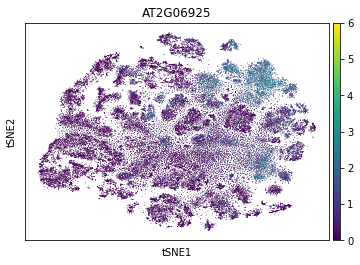

In [5]:
color_name = "AT2G06925"
tissue = "Root"
data_name = "05SRP171040_new_rice_SRP309176_filter_all"
sc.pl.tsne(adata_mod1_new, color=[color_name], wspace=0.65,show=True, save= tissue + "_" +data_name + '_adata_pca_'+ color_name +'_plot',
          vmin=0,vmax=6)


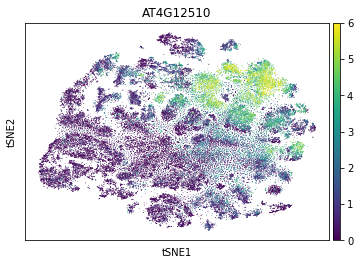

In [6]:
color_name = "AT4G12510"
tissue = "Root"
data_name = "05SRP171040_new_rice_SRP309176_filter_all"
sc.pl.tsne(adata_mod1_new, color=[color_name], wspace=0.65,show=True, save= tissue + "_" +data_name + '_adata_pca_'+ color_name +'_plot',
          vmin=0,vmax=6)
